## Importing the relevant libraries

In [299]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse, meanabs, rmse
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from datetime import datetime
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation

## Loading the dataset

In [4]:
df = pd.read_csv('../../DATA/UNRATE.csv',index_col=0,parse_dates=True)
df.head()

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


## Data Exploration

In [6]:
df.shape

(920, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 920 entries, 1948-01-01 to 2024-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNRATE  920 non-null    float64
dtypes: float64(1)
memory usage: 14.4 KB


In [8]:
df.isna().sum()

UNRATE    0
dtype: int64

In [9]:
df.index

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01',
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01'],
              dtype='datetime64[ns]', name='DATE', length=920, freq=None)

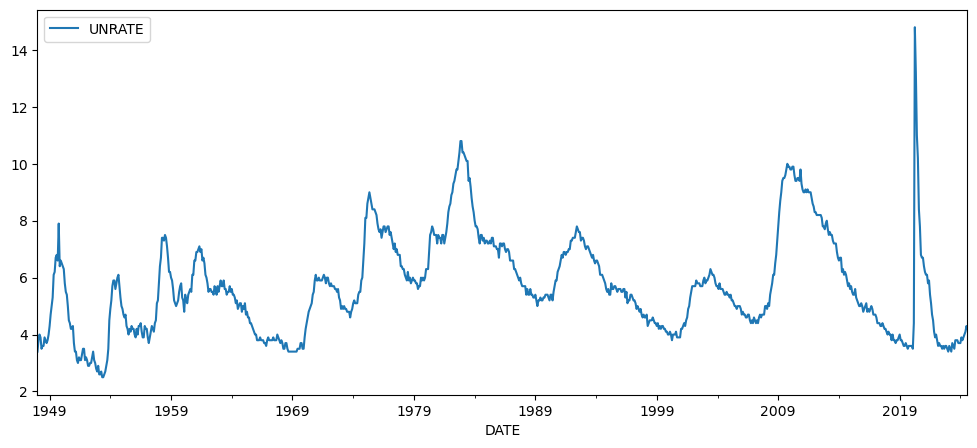

In [10]:
df.plot(figsize=(12,5));

In [11]:
df.index.freq = 'MS' # Setting frequency of time series to Monthly-Start

## Performing ETS Decomposition

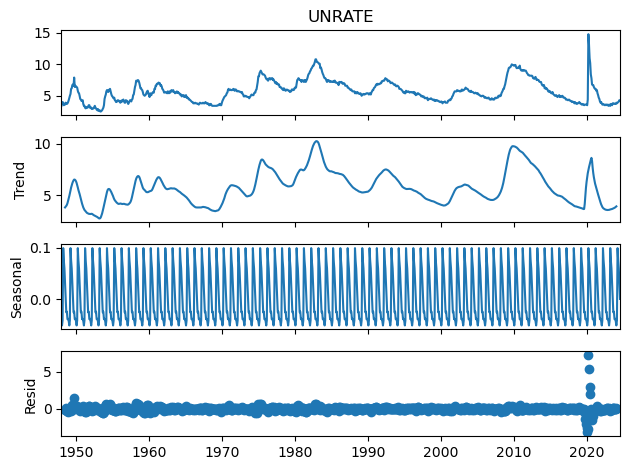

In [13]:
results = seasonal_decompose(df.UNRATE,model='additive')
results.plot();

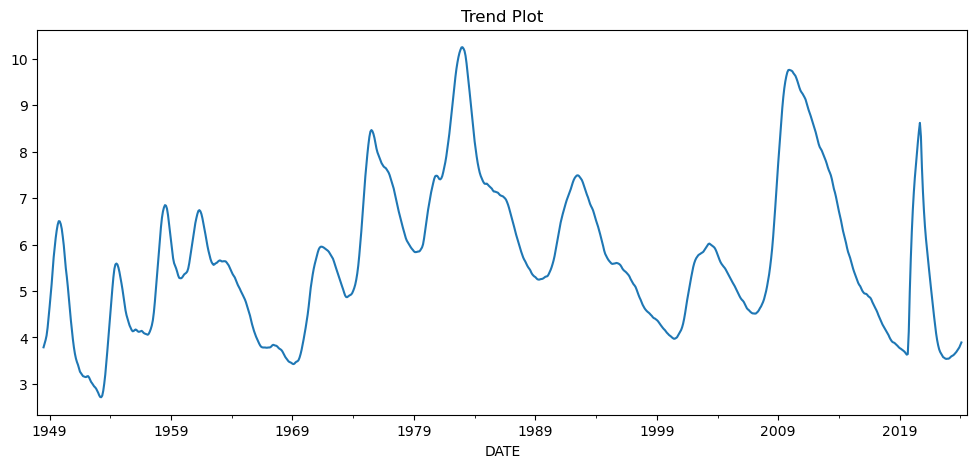

In [14]:
results.trend.plot(figsize=(12,5),title='Trend Plot');

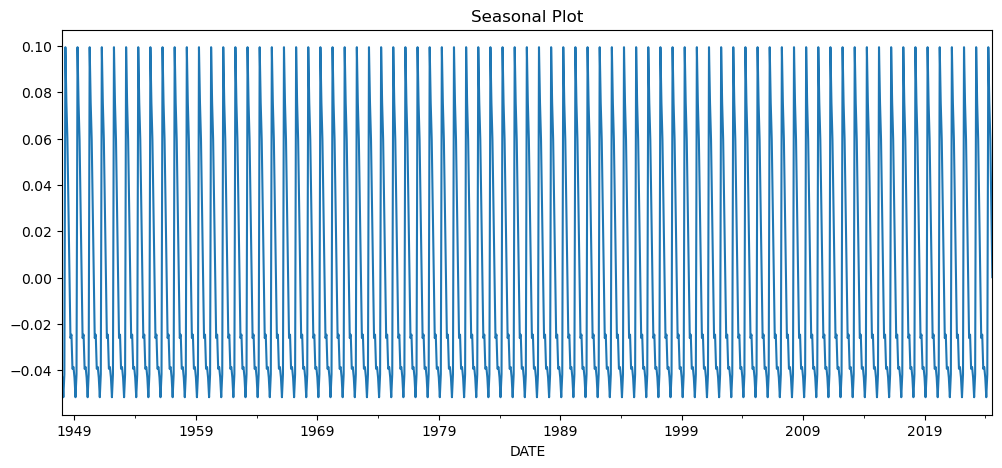

In [15]:
results.seasonal.plot(figsize=(12,5),title='Seasonal Plot');

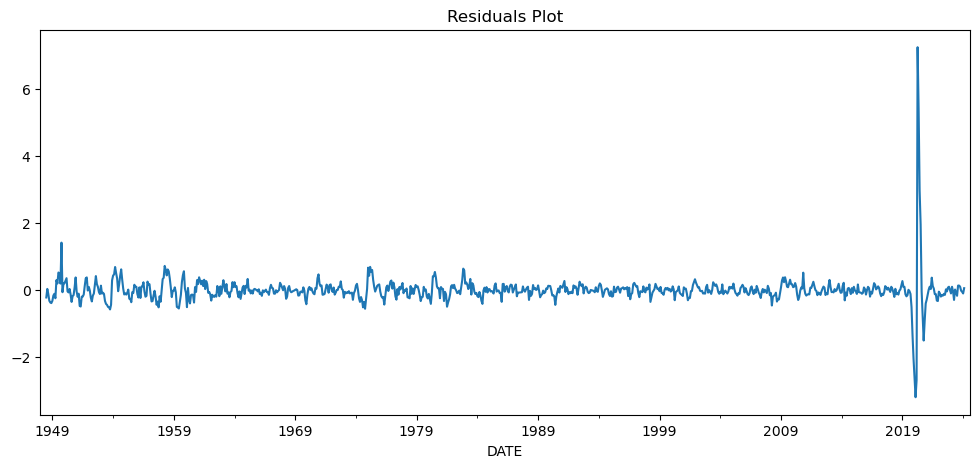

In [16]:
results.resid.plot(figsize=(12,5),title='Residuals Plot');

## Examining SMA, EWMA and Holt-Winters models

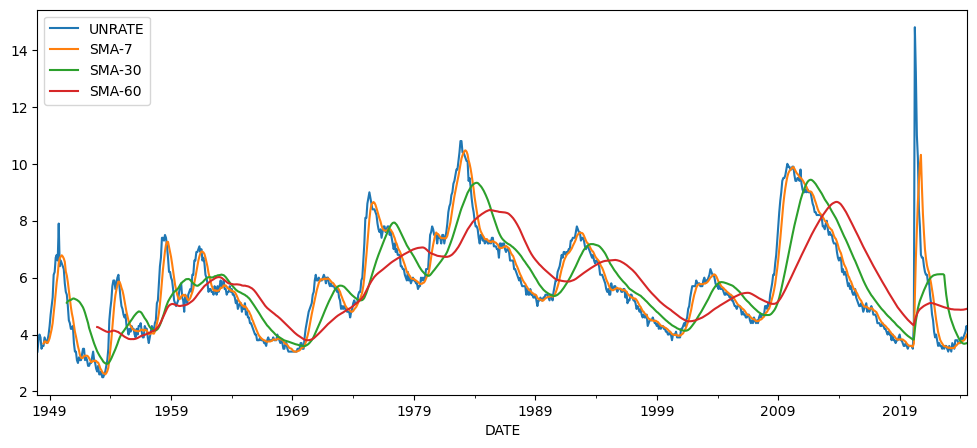

In [18]:
df['SMA-7'] = df.UNRATE.rolling(window=7,).mean() 
df['SMA-30'] = df.UNRATE.rolling(window=30).mean()
df['SMA-60'] = df.UNRATE.rolling(window=60).mean()
df.plot(figsize=(12,5));

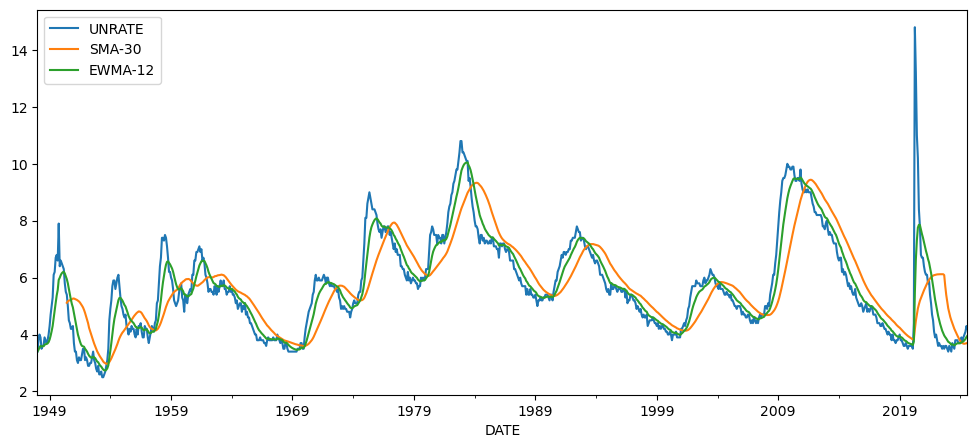

In [19]:
span = 12
alpha = 2/(span+1)

df['EWMA-12'] = df['UNRATE'].ewm(alpha=alpha,adjust=False).mean()
df[['UNRATE','SMA-30','EWMA-12']].plot(figsize=(12,5));

In [20]:
ses = SimpleExpSmoothing(df['UNRATE'])
fittedmodel = ses.fit(smoothing_level=alpha,optimized=False)
fittedmodel

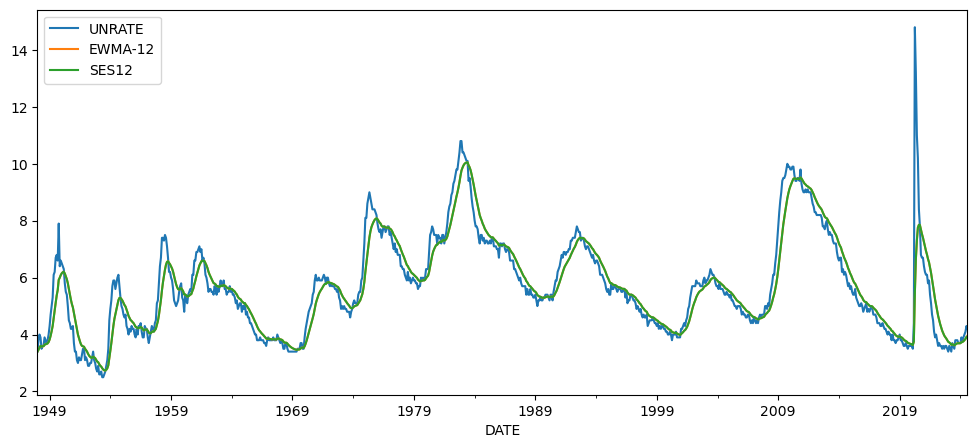

In [21]:
df['SES12'] = fittedmodel.fittedvalues.shift(-1)
df[['UNRATE','EWMA-12','SES12']].plot(figsize=(12,5));

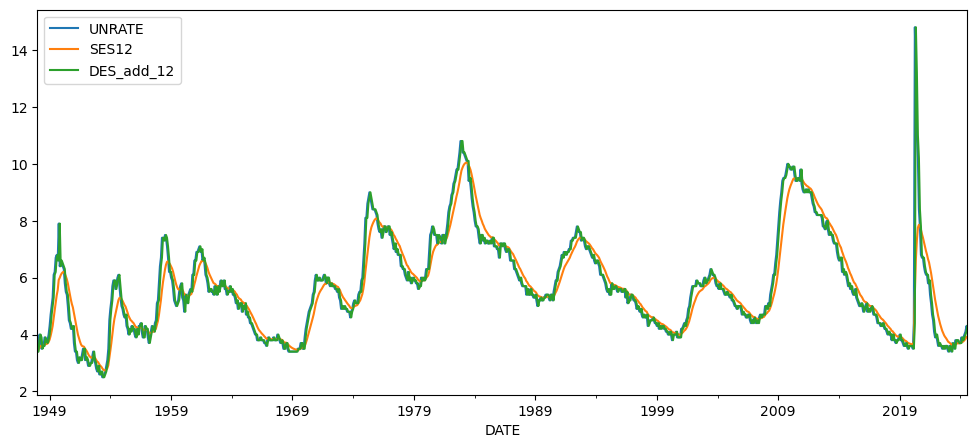

In [22]:
df['DES_add_12'] = ExponentialSmoothing(df['UNRATE'],trend='add').fit().fittedvalues
df[['UNRATE','SES12','DES_add_12']].plot(figsize=(12,5));

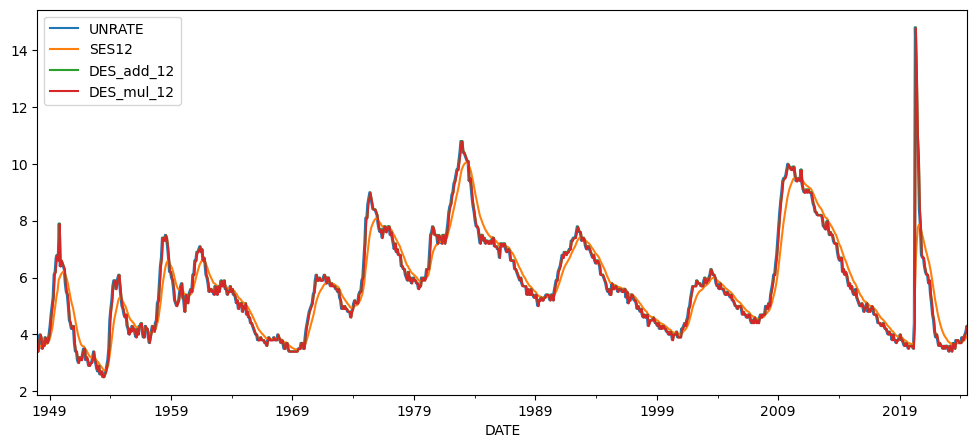

In [23]:
df['DES_mul_12'] = ExponentialSmoothing(df['UNRATE'],trend='mul').fit().fittedvalues
df[['UNRATE','SES12','DES_add_12','DES_mul_12']].plot(figsize=(12,5));

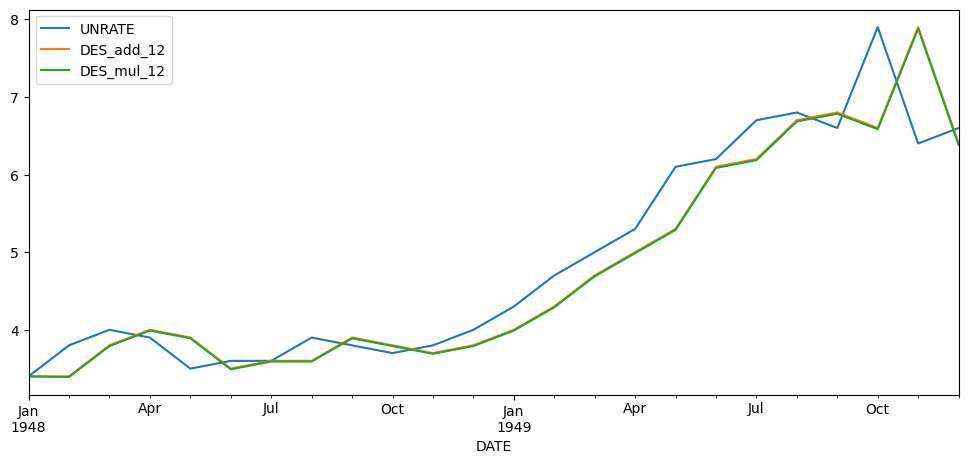

In [24]:
df[['UNRATE','DES_add_12','DES_mul_12']].iloc[:24].plot(figsize=(12,5));

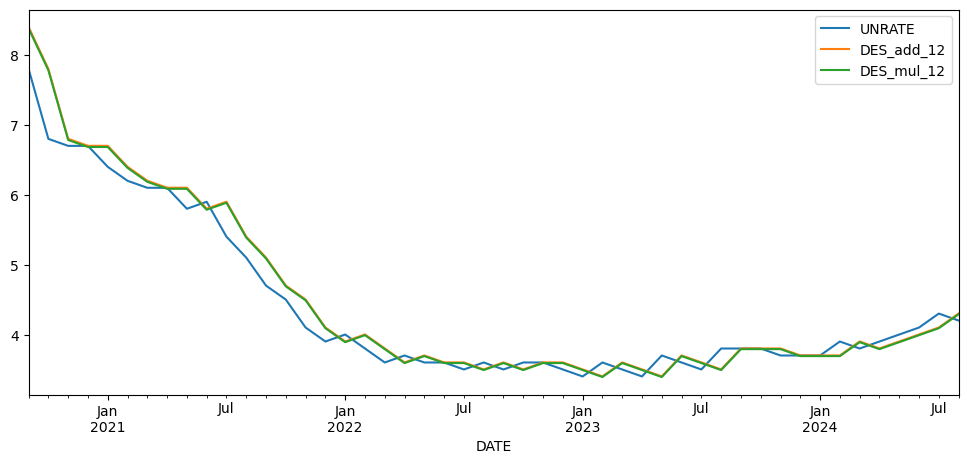

In [25]:
df[['UNRATE','DES_add_12','DES_mul_12']].iloc[-48:].plot(figsize=(12,5));

In [26]:
print("MAE of DES additive 12:", meanabs(df['UNRATE'],df['DES_add_12']))
print("MAE of DES multiplicative 12:", meanabs(df['UNRATE'],df['DES_mul_12']))
print("RMSE of DES additive 12:", np.sqrt(mse(df['UNRATE'],df['DES_add_12'])))
print("RMSE of DES multiplicative 12:", np.sqrt(mse(df['UNRATE'],df['DES_mul_12'])))

MAE of DES additive 12: 0.16483120161349488
MAE of DES multiplicative 12: 0.16660145392304748
RMSE of DES additive 12: 0.41762697086829853
RMSE of DES multiplicative 12: 0.41738888479030606


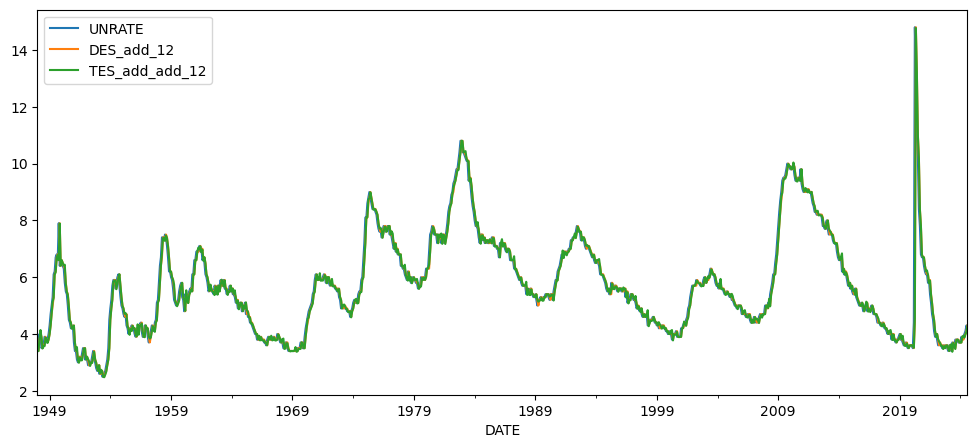

In [27]:
df['TES_add_add_12'] = ExponentialSmoothing(df['UNRATE'],trend='add',seasonal='add').fit().fittedvalues
df[['UNRATE','DES_add_12','TES_add_add_12']].plot(figsize=(12,5));

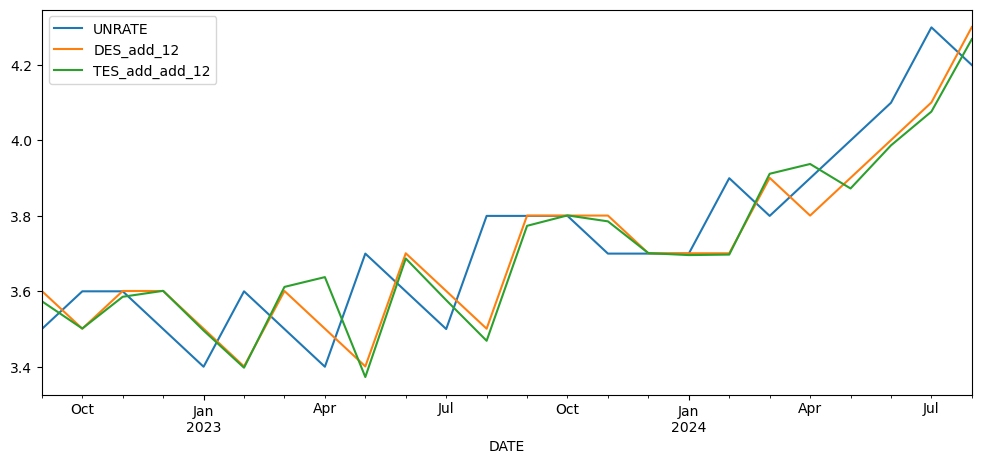

In [28]:
df[['UNRATE','DES_add_12','TES_add_add_12']].iloc[-24:].plot(figsize=(12,5));

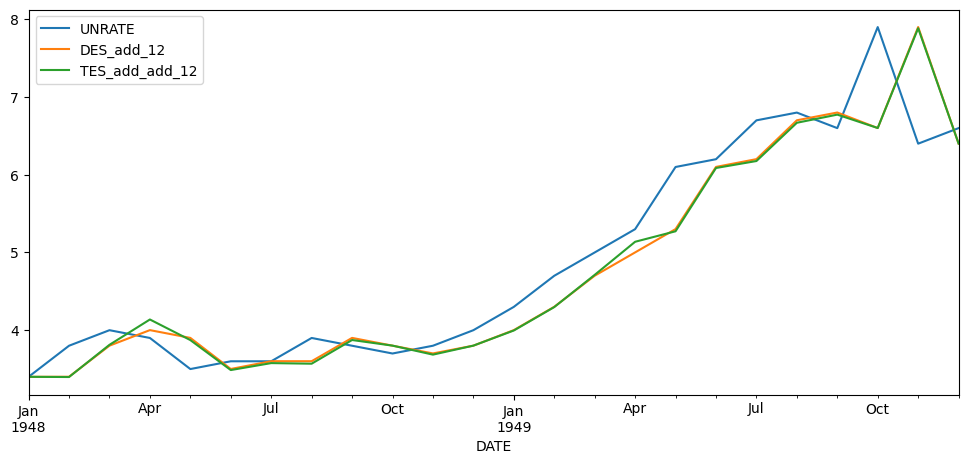

In [29]:
df[['UNRATE','DES_add_12','TES_add_add_12']].iloc[:24].plot(figsize=(12,5));

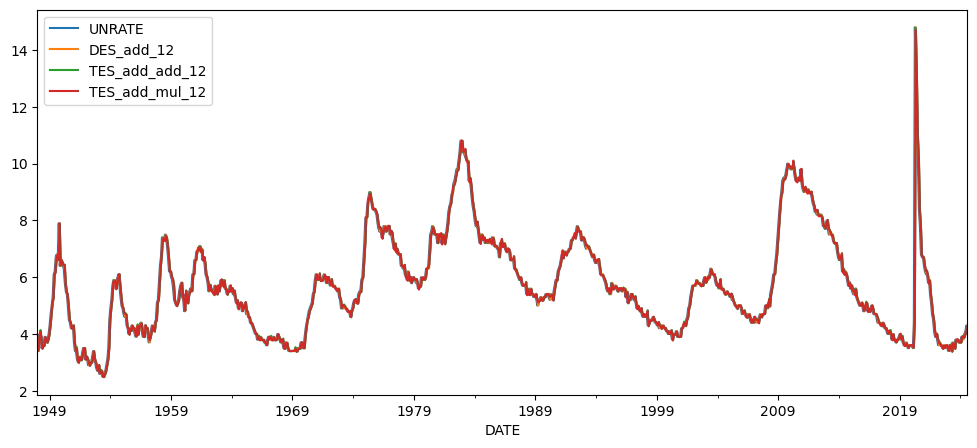

In [30]:
df['TES_add_mul_12'] = ExponentialSmoothing(df['UNRATE'],trend='add',seasonal='mul').fit().fittedvalues
df[['UNRATE','DES_add_12','TES_add_add_12','TES_add_mul_12']].plot(figsize=(12,5));

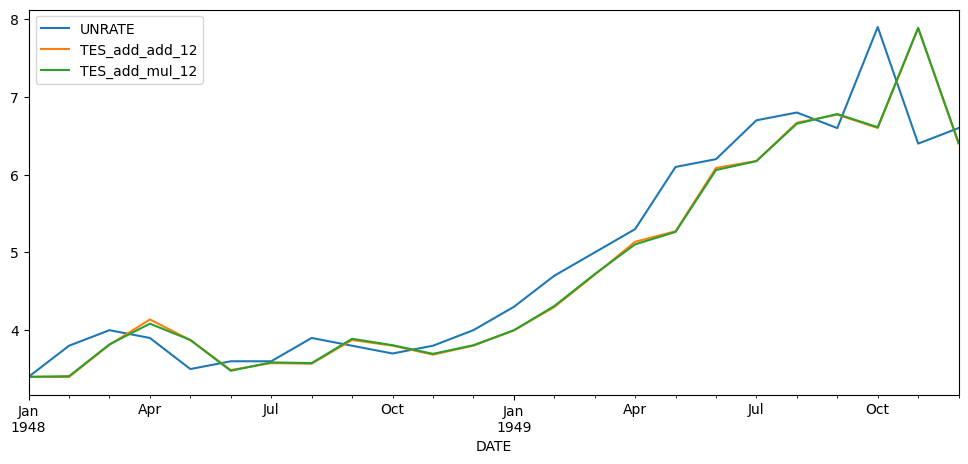

In [31]:
df[['UNRATE','TES_add_add_12','TES_add_mul_12']].iloc[:24].plot(figsize=(12,5));

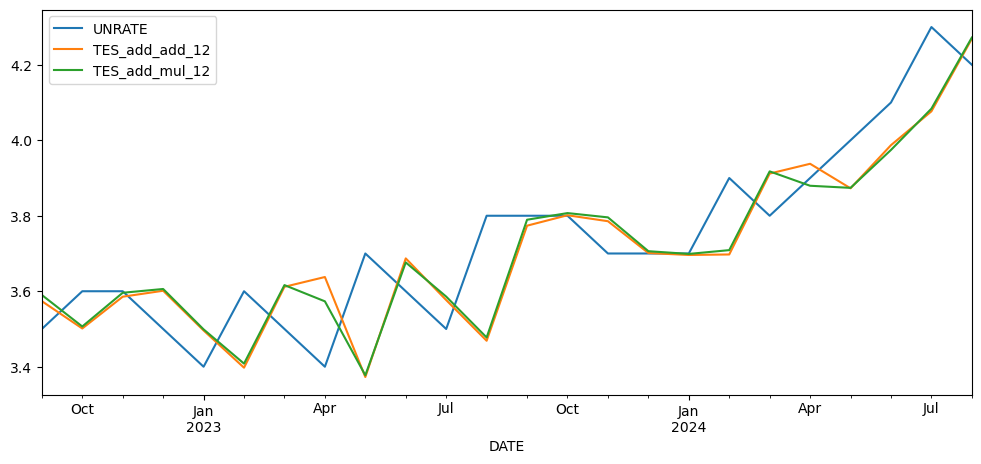

In [32]:
df[['UNRATE','TES_add_add_12','TES_add_mul_12']].iloc[-24:].plot(figsize=(12,5));

D:\Anaconda\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


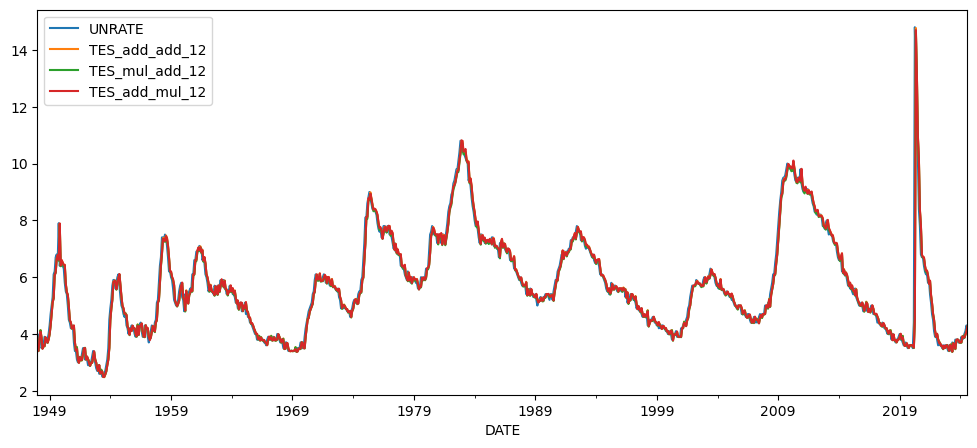

In [33]:
df['TES_mul_add_12'] = ExponentialSmoothing(df['UNRATE'],trend='mul',seasonal='add').fit().fittedvalues
df[['UNRATE','TES_add_add_12','TES_mul_add_12','TES_add_mul_12']].plot(figsize=(12,5));

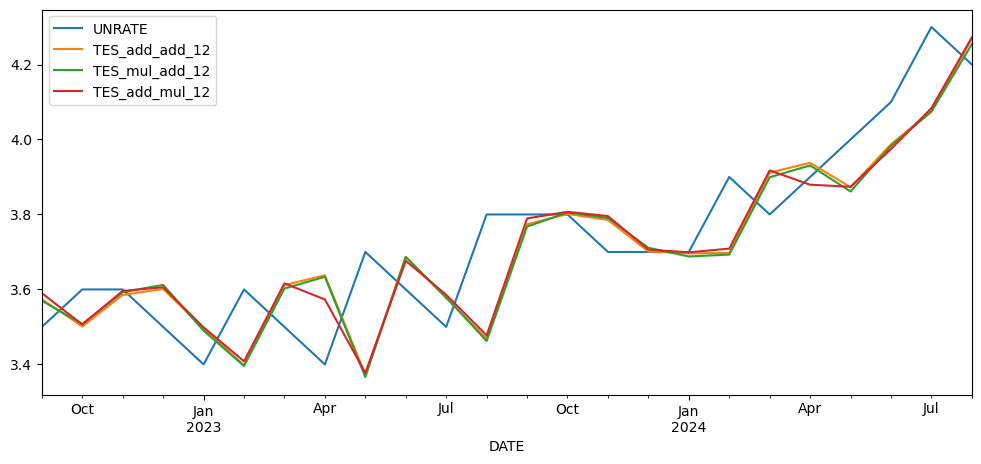

In [34]:
df[['UNRATE','TES_add_add_12','TES_mul_add_12','TES_add_mul_12']].iloc[-24:].plot(figsize=(12,5));

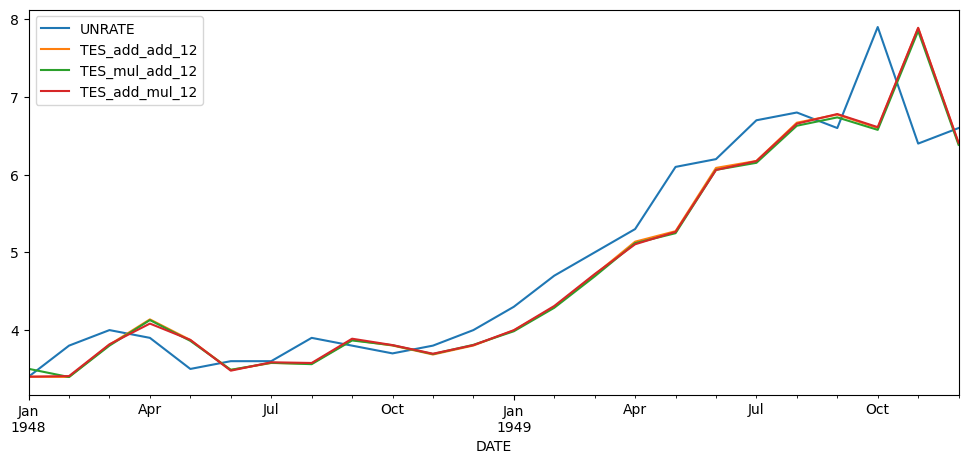

In [35]:
df[['UNRATE','TES_add_add_12','TES_mul_add_12','TES_add_mul_12']].iloc[:24].plot(figsize=(12,5));

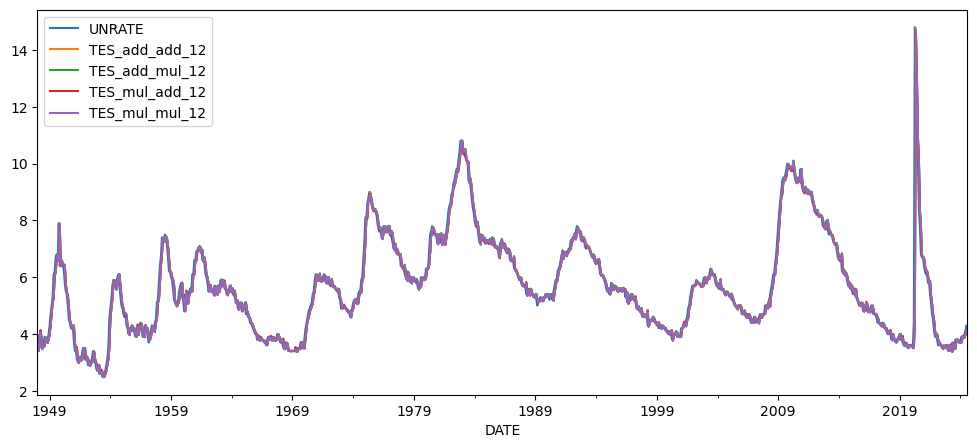

In [36]:
df['TES_mul_mul_12'] = ExponentialSmoothing(df['UNRATE'],trend='mul',seasonal='mul').fit().fittedvalues
df[['UNRATE','TES_add_add_12','TES_add_mul_12','TES_mul_add_12','TES_mul_mul_12']].plot(figsize=(12,5));

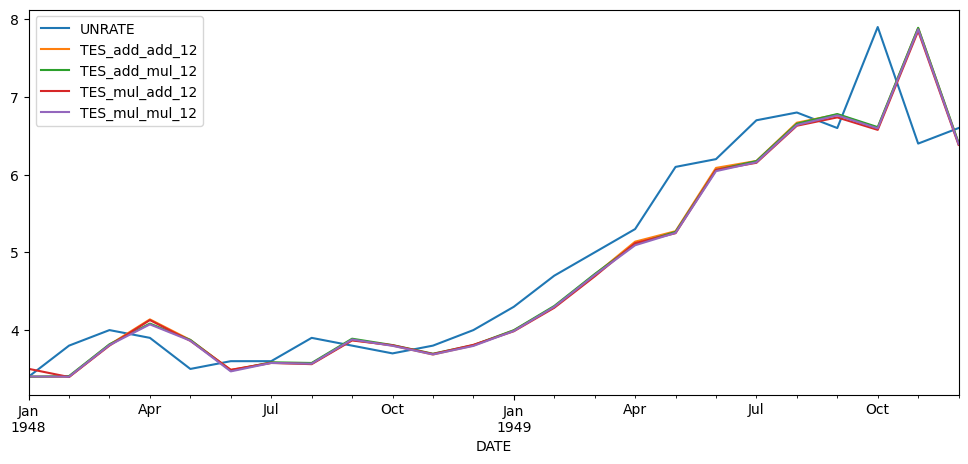

In [37]:
df[['UNRATE','TES_add_add_12','TES_add_mul_12','TES_mul_add_12','TES_mul_mul_12']].iloc[:24].plot(figsize=(12,5));

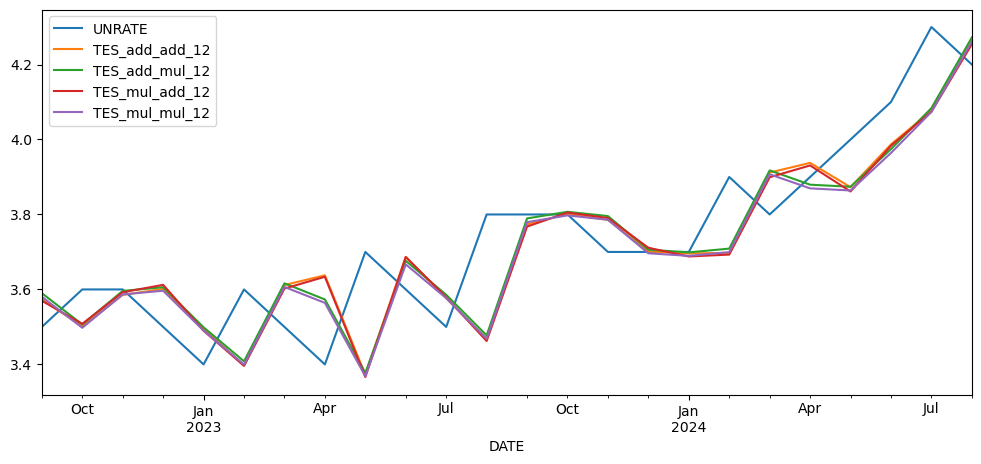

In [38]:
df[['UNRATE','TES_add_add_12','TES_add_mul_12','TES_mul_add_12','TES_mul_mul_12']].iloc[-24:].plot(figsize=(12,5));

In [39]:
print("RMSE of TES_add_add_12:", np.sqrt(mse(df['UNRATE'],df['TES_add_add_12'])))
print("RMSE of TES_add_mul_12:", np.sqrt(mse(df['UNRATE'],df['TES_add_mul_12'])))
print("RMSE of TES_mul_add_12:", np.sqrt(mse(df['UNRATE'],df['TES_mul_add_12'])))
print("RMSE of TES_mul_mul_12:", np.sqrt(mse(df['UNRATE'],df['TES_mul_mul_12'])))

RMSE of TES_add_add_12: 0.41537384681895323
RMSE of TES_add_mul_12: 0.4154389112475408
RMSE of TES_mul_add_12: 0.41427292169937163
RMSE of TES_mul_mul_12: 0.41521863772190537


In [40]:
hw_model = Holt(df['UNRATE'])
fittedmodel = hw_model.fit()
fittedmodel

In [41]:
fittedmodel.aic

-1565.9360288783005

In [42]:
fittedmodel.sse

166.2634599981593

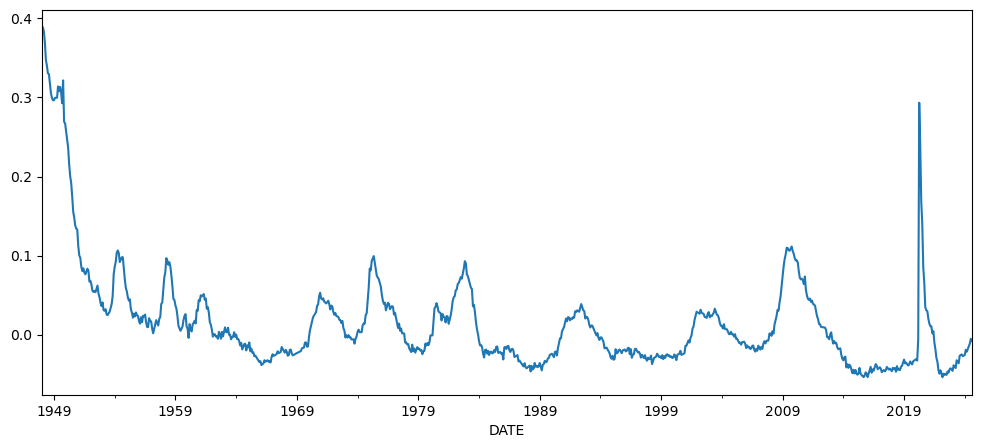

In [43]:
fittedmodel.trend.plot(figsize=(12,5));

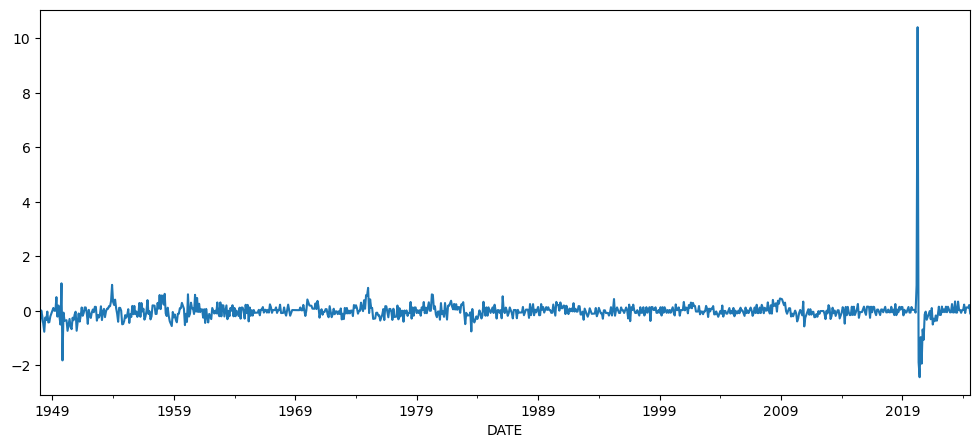

In [44]:
fittedmodel.resid.plot(figsize=(12,5));

In [45]:
fittedmodel.bic

-1546.6385341981281

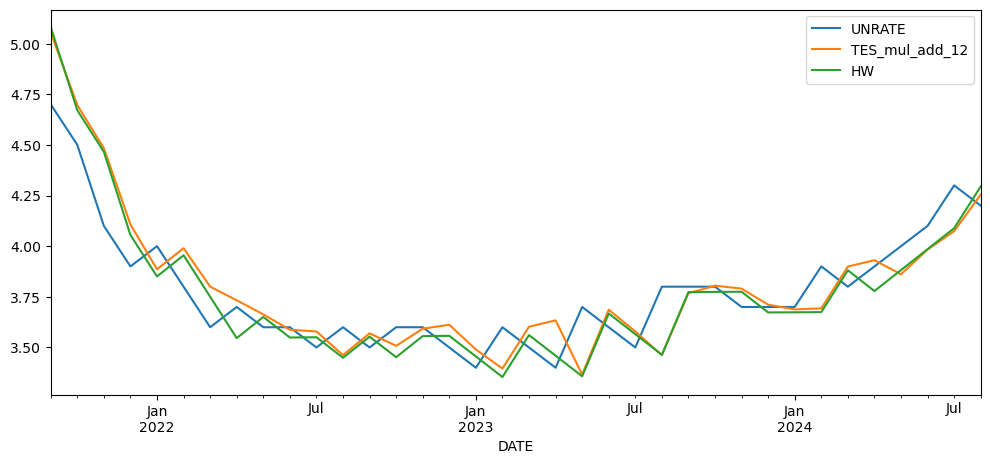

In [46]:
df['HW'] = fittedmodel.fittedvalues
df[['UNRATE','TES_mul_add_12','HW']].iloc[-36:].plot(figsize=(12,5));

In [47]:
print("RMSE of Holt-Winters model:", np.sqrt(mse(df['UNRATE'],df['HW'])))

RMSE of Holt-Winters model: 0.42511310515192574


## Running descriptive statistics tests to test stationarity of time series

In [49]:
def adf_test(series,title=''):
    print(f"Augmented Dickey-Fuller Test: {title}")
    adf_results = adfuller(series.dropna(),autolag='AIC')
    df_results = pd.Series(adf_results[:4],index=['test-statistic','p-value','# lags','# observations'])
    
    for key, val in adf_results[4].items():
        df_results[f'critical_val_{key}'] = val
    
    print(df_results.to_string())
    
    if adf_results[1] <= 0.05:
        print("Strong evidence against null hypothesis.")
        print("Reject the null hypothesis.")
        print("Data has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis.")
        print("Fail to reject the null hypothesis.")
        print("Data has a unit root and is non-stationary.")

In [50]:
adf_test(df['UNRATE'])

Augmented Dickey-Fuller Test: 
test-statistic       -3.923921
p-value               0.001866
# lags                1.000000
# observations      918.000000
critical_val_1%      -3.437493
critical_val_5%      -2.864694
critical_val_10%     -2.568449
Strong evidence against null hypothesis.
Reject the null hypothesis.
Data has no unit root and is stationary.


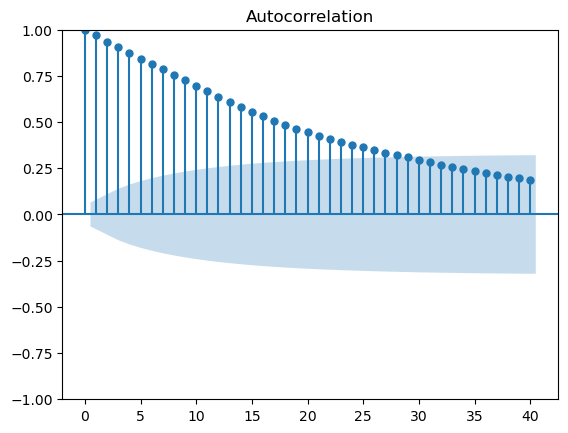

In [51]:
plot_acf(df['UNRATE'],lags=40);

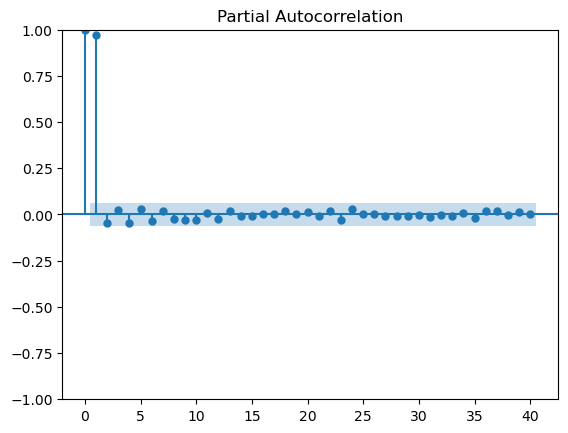

In [52]:
plot_pacf(df['UNRATE'],lags=40);

## Applying Auto ARIMA to determine the most optimal ARIMA orders

In [54]:
res = auto_arima(df['UNRATE'],start_p=0,start_q=0,start_P=0,start_Q=0,seasonal=True,m=12,suppress_warnings=False,trace=True)
res.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1008.128, Time=0.93 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1010.178, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1010.029, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1006.132, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1009.363, Time=0.18 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1009.324, Time=0.21 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1010.333, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1008.943, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1008.833, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1004.922, Time=0.32 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1006.386, Time=0.70 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1006.362, Time=0.92 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1007.639, Time=1.45 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1006.626, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=1002.926, Time=0.18 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=1004.389, Time=0.31 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=1004.366, Time=0.39 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=1005.644, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1006.836, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=1006.947, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=1004.630, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=1004.637, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=1006.896, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=1007.299, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=inf, Time=0.68 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 11.386 seconds


D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  920
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -498.463
Date:                Mon, 07 Oct 2024   AIC                           1002.926
Time:                        16:27:59   BIC                           1017.396
Sample:                    01-01-1948   HQIC                          1008.448
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7778      0.077    -10.041      0.000      -0.930      -0.626
ma.L1          0.8336      0.074     11.291      0.000       0.689       0.978
sigma2         0.1732      0.001    287.410      0.000       0.172       0.174
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):           6614391.51
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               6.41   Skew:                            16.44
Prob(H) (two-sided):                  0.00   Kurtosis:                       417.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
res.aic()

1002.9258436822247

The most optimal order of ARIMA recommended by Auto ARIMA for this dataset is (1,1,1). Surprisingly, it neglects the seasonal component.

## Dividing the dataset into train and test sets

In [58]:
len(df)

920

In [59]:
train = df[:896]
test = df[896:]

In [60]:
train.shape, test.shape

((896, 13), (24, 13))

## Performing ARIMA modeling

In [62]:
arima = ARIMA(train['UNRATE'],order=(1,1,1))
results = arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 UNRATE   No. Observations:                  896
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -496.008
Date:                Mon, 07 Oct 2024   AIC                            998.016
Time:                        16:28:00   BIC                           1012.407
Sample:                    01-01-1948   HQIC                          1003.515
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7806      0.079     -9.941      0.000      -0.934      -0.627
ma.L1          0.8365      0.075     11.185      0.000       0.690       0.983
sigma2         0.1774      0.001    280.405      0.000       0.176       0.179
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):           6181258.02
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               6.46   Skew:                            16.30
Prob(H) (two-sided):                  0.00   Kurtosis:                       408.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
test_predictions = results.predict(start=len(train),end=len(train)+len(test)-1,typ='levels').rename('ARIMA(1,1,1) Predictions') # Making predictions on the test set
test_predictions

2022-09-01    3.623122
2022-10-01    3.605074
2022-11-01    3.619162
2022-12-01    3.608165
2023-01-01    3.616749
2023-02-01    3.610049
2023-03-01    3.615278
2023-04-01    3.611196
2023-05-01    3.614383
2023-06-01    3.611896
2023-07-01    3.613837
2023-08-01    3.612322
2023-09-01    3.613504
2023-10-01    3.612581
2023-11-01    3.613302
2023-12-01    3.612739
2024-01-01    3.613178
2024-02-01    3.612836
2024-03-01    3.613103
2024-04-01    3.612894
2024-05-01    3.613057
2024-06-01    3.612930
2024-07-01    3.613029
2024-08-01    3.612952
Freq: MS, Name: ARIMA(1,1,1) Predictions, dtype: float64

In [64]:
# Evaluating ARIMA model predictions
print("MAE:", meanabs(test['UNRATE'],test_predictions))
print("MSE:", mse(test['UNRATE'],test_predictions))
print("RMSE:", rmse(test['UNRATE'],test_predictions))

MAE: 0.1979881894672648
MSE: 0.07015808697637749
RMSE: 0.264873718923523


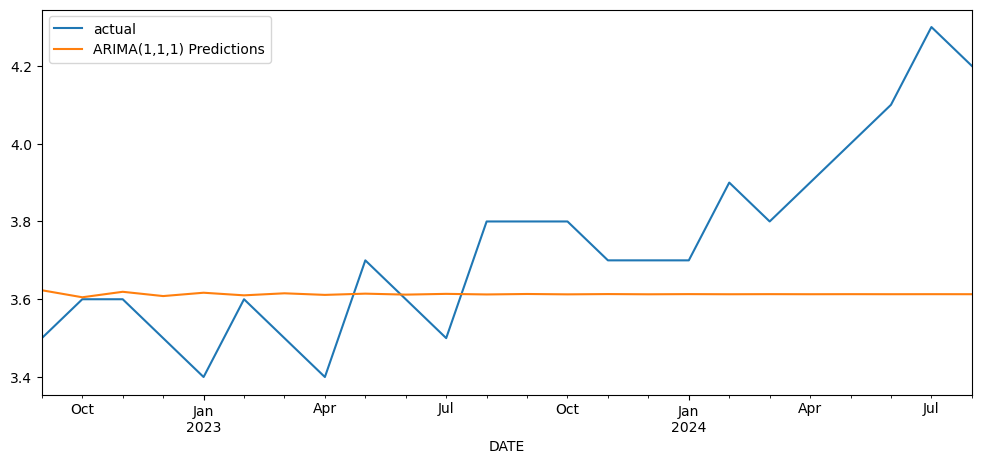

In [65]:
test['UNRATE'].plot(figsize=(12,5),legend=True,label='actual')
test_predictions.plot(legend=True);

Not the worst predictions going by the trend. Despite the simplicity of the ARIMA model, it's performance on the test set is relatively decent.

## Forecasting into the future using ARIMA(1,1,1)

In [68]:
arima = ARIMA(df['UNRATE'],order=(1,1,1))
results = arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 UNRATE   No. Observations:                  920
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -498.463
Date:                Mon, 07 Oct 2024   AIC                           1002.926
Time:                        16:28:00   BIC                           1017.396
Sample:                    01-01-1948   HQIC                          1008.448
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7778      0.077    -10.041      0.000      -0.930      -0.626
ma.L1          0.8336      0.074     11.291      0.000       0.689       0.978
sigma2         0.1732      0.001    287.410      0.000       0.172       0.174
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):           6614391.51
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               6.41   Skew:                            16.44
Prob(H) (two-sided):                  0.00   Kurtosis:                       417.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
test_predictions = results.predict(start=len(df),end=len(df)+len(test)-1,typ='levels').rename('ARIMA(1,1,1) Forecast')
test_predictions

2024-09-01    4.197287
2024-10-01    4.199397
2024-11-01    4.197756
2024-12-01    4.199033
2025-01-01    4.198039
2025-02-01    4.198812
2025-03-01    4.198211
2025-04-01    4.198678
2025-05-01    4.198315
2025-06-01    4.198598
2025-07-01    4.198378
2025-08-01    4.198549
2025-09-01    4.198416
2025-10-01    4.198519
2025-11-01    4.198439
2025-12-01    4.198501
2026-01-01    4.198453
2026-02-01    4.198490
2026-03-01    4.198461
2026-04-01    4.198484
2026-05-01    4.198466
2026-06-01    4.198480
2026-07-01    4.198469
2026-08-01    4.198478
Freq: MS, Name: ARIMA(1,1,1) Forecast, dtype: float64

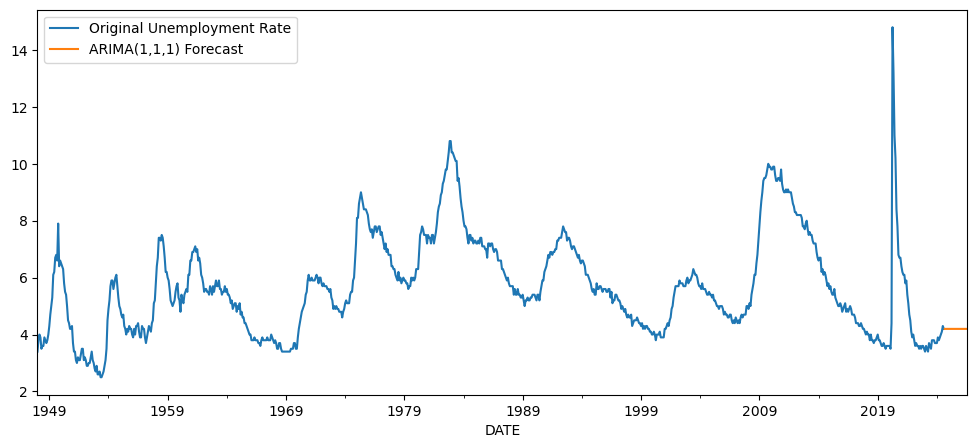

In [70]:
df['UNRATE'].plot(figsize=(12,5),legend=True,label='Original Unemployment Rate')
test_predictions.plot(legend=True);

## Time Series Forecasting using LSTMs

### Scaling the time series into (0,1) range

In [73]:
scaler = MinMaxScaler()
train['UNRATE'] = scaler.fit_transform(train[['UNRATE']])

In [74]:
test['UNRATE'] = scaler.transform(test[['UNRATE']])

In [75]:
train.head()

,UNRATE,SMA-7,SMA-30,SMA-60,EWMA-12,SES12,DES_add_12,DES_mul_12,TES_add_add_12,TES_add_mul_12,TES_mul_add_12,TES_mul_mul_12,HW
DATE,,,,,,,,,,,,,
1948-01-01,0.073171,NaN,NaN,NaN,3.400000,3.400000,3.399986,3.400003,3.400008,3.400029,3.501547,3.402692,3.800000
1948-02-01,0.105691,NaN,NaN,NaN,3.461538,3.461538,3.400871,3.391913,3.397421,3.408270,3.396026,3.399570,3.788495
1948-03-01,0.121951,NaN,NaN,NaN,3.544379,3.544379,3.800871,3.790962,3.811714,3.817113,3.800284,3.806950,4.188826
1948-04-01,0.113821,NaN,NaN,NaN,3.599090,3.599090,4.000871,3.990486,4.137678,4.083582,4.128719,4.073320,4.383394
1948-05-01,0.081301,NaN,NaN,NaN,3.583845,3.583845,3.900871,3.890724,3.872727,3.873877,3.861283,3.863930,4.269490


In [76]:
test.head()

,UNRATE,SMA-7,SMA-30,SMA-60,EWMA-12,SES12,DES_add_12,DES_mul_12,TES_add_add_12,TES_add_mul_12,TES_mul_add_12,TES_mul_mul_12,HW
DATE,,,,,,,,,,,,,
2022-09-01,0.081301,3.585714,6.090000,4.958333,3.968315,3.968315,3.600871,3.591437,3.573675,3.590060,3.569723,3.580479,3.553494
2022-10-01,0.089431,3.585714,5.716667,4.948333,3.911651,3.911651,3.500871,3.491675,3.501329,3.506581,3.508170,3.497757,3.451955
2022-11-01,0.089431,3.571429,5.396667,4.938333,3.863705,3.863705,3.600871,3.591437,3.585512,3.595965,3.592582,3.586624,3.556213
2022-12-01,0.081301,3.557143,5.146667,4.928333,3.807750,3.807750,3.600871,3.591437,3.601289,3.605963,3.612215,3.596557,3.557473
2023-01-01,0.073171,3.528571,4.920000,4.918333,3.745020,3.745020,3.500871,3.491675,3.496072,3.498965,3.489990,3.490110,3.455820


### Creating batches of time series steps using Time Series Generator with length of each series being 2 years

In [78]:
n_inputs = 24
n_features = 1

train_generator = TimeseriesGenerator(train['UNRATE'].values,train['UNRATE'].values,length=n_inputs,batch_size=1)
train_generator

In [79]:
len(train), len(train_generator)

(896, 872)

In [80]:
test_generator = TimeseriesGenerator(test['UNRATE'].values,test['UNRATE'].values,length=4,batch_size=1)
test_generator

In [81]:
len(test), len(test_generator)

(24, 20)

In [82]:
X, y = train_generator[0]
X, y

(array([[0.07317073, 0.10569106, 0.12195122, 0.11382114, 0.08130081,
         0.08943089, 0.08943089, 0.11382114, 0.10569106, 0.09756098,
         0.10569106, 0.12195122, 0.14634146, 0.17886179, 0.20325203,
         0.22764228, 0.29268293, 0.30081301, 0.34146341, 0.3495935 ,
         0.33333333, 0.43902439, 0.31707317, 0.33333333]]),
 array([0.32520325]))

In [83]:
X.shape, y.shape

((1, 24), (1,))

### Defining the LSTM model architecture

In [85]:
model = Sequential()
model.add(LSTM(units=150,activation='relu',input_shape=(n_inputs,n_features)))
model.add(Dense(units=1))
model.summary();

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 150)                 │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(loss='mse',optimizer='adam')

### Training LSTM model on the training set

In [88]:
model.fit(train_generator,epochs=25)

Epoch 1/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0063
Epoch 2/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0014
Epoch 3/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0013
Epoch 4/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0019
Epoch 5/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0011
Epoch 6/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0029
Epoch 7/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.3857e-04
Epoch 8/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 6.1964e-04
Epoch 9/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.7758e-04
Epoch 10/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0013
Epoch 11/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5.1562e-04
Epoch 12/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.3269e-04
Epoch 13/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0018
Epoch 14/25
872/872 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 9.7717e-04
Epoch 15/25
872/872 ━━━━━━━━━━

### Examining the loss per epoch

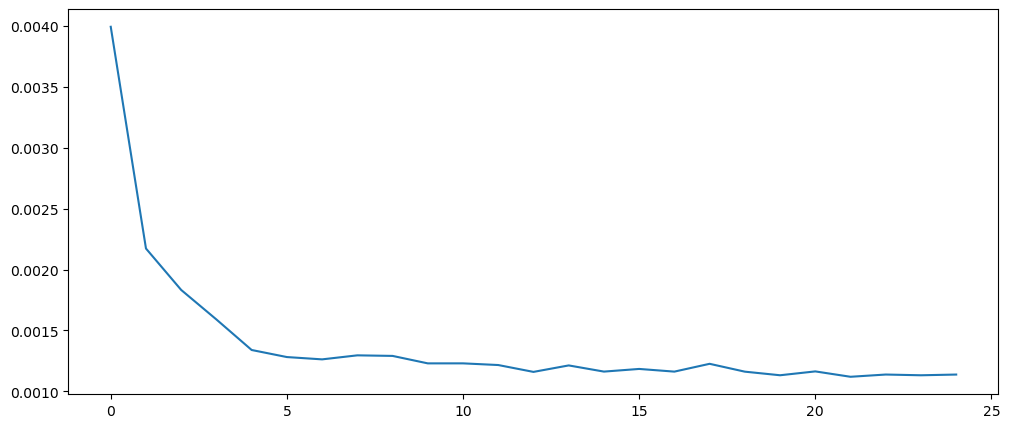

In [90]:
plt.figure(figsize=(12,5))
plt.plot(range(25),model.history.history['loss']);

### Making predictions on the test set

In [92]:
first_eval_batch = train['UNRATE'].iloc[-n_inputs:].values
first_eval_batch

array([0.43089431, 0.3495935 , 0.34146341, 0.34146341, 0.31707317,
       0.30081301, 0.29268293, 0.29268293, 0.26829268, 0.27642276,
       0.23577236, 0.21138211, 0.17886179, 0.16260163, 0.1300813 ,
       0.11382114, 0.12195122, 0.10569106, 0.08943089, 0.09756098,
       0.08943089, 0.08943089, 0.08130081, 0.08943089])

In [93]:
first_eval_batch = first_eval_batch.reshape((1,n_inputs,n_features))
first_eval_batch

array([[[0.43089431],
        [0.3495935 ],
        [0.34146341],
        [0.34146341],
        [0.31707317],
        [0.30081301],
        [0.29268293],
        [0.29268293],
        [0.26829268],
        [0.27642276],
        [0.23577236],
        [0.21138211],
        [0.17886179],
        [0.16260163],
        [0.1300813 ],
        [0.11382114],
        [0.12195122],
        [0.10569106],
        [0.08943089],
        [0.09756098],
        [0.08943089],
        [0.08943089],
        [0.08130081],
        [0.08943089]]])

In [94]:
model.predict(first_eval_batch)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


0.119506046

In [95]:
test_predictions = []
first_eval_batch = train['UNRATE'].iloc[-n_inputs:].values
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [96]:
test_predictions = np.array(test_predictions)
test_predictions

array([[0.11950605],
       [0.1531303 ],
       [0.19261178],
       [0.23733476],
       [0.2855526 ],
       [0.3346155 ],
       [0.3821733 ],
       [0.42626318],
       [0.46537498],
       [0.49882445],
       [0.52674097],
       [0.54936546],
       [0.56706977],
       [0.5803353 ],
       [0.58970994],
       [0.5957674 ],
       [0.5990764 ],
       [0.6001772 ],
       [0.59953946],
       [0.5975648 ],
       [0.59462476],
       [0.5910382 ],
       [0.587074  ],
       [0.5829531 ]], dtype=float32)

In [97]:
test.shape, test_predictions.shape

((24, 13), (24, 1))

In [98]:
print("MAE:", mean_absolute_error(test['UNRATE'].values,test_predictions))
print("MAPE:", mean_absolute_percentage_error(test['UNRATE'].values,test_predictions))
print("MSE:", mean_squared_error(test['UNRATE'].values,test_predictions))
print("RMSE:", np.sqrt(mean_squared_error(test['UNRATE'].values,test_predictions)))

MAE: 0.36874665008469165
MAPE: 3.643449493153939
MSE: 0.15756492140394196
RMSE: 0.3969444815134


In [99]:
true_predictions = scaler.inverse_transform(test_predictions.reshape(-1,1))
true_predictions

array([[3.9699244],
       [4.383503 ],
       [4.869125 ],
       [5.4192176],
       [6.012297 ],
       [6.615771 ],
       [7.2007313],
       [7.743037 ],
       [8.2241125],
       [8.635541 ],
       [8.978913 ],
       [9.2571945],
       [9.474958 ],
       [9.638124 ],
       [9.753432 ],
       [9.827939 ],
       [9.868639 ],
       [9.882179 ],
       [9.874335 ],
       [9.850047 ],
       [9.813885 ],
       [9.76977  ],
       [9.72101  ],
       [9.670322 ]], dtype=float32)

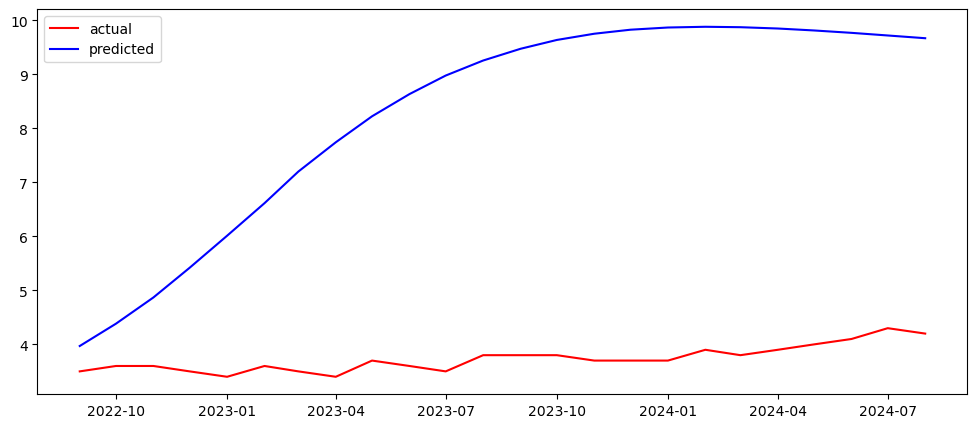

In [100]:
plt.figure(figsize=(12,5))
plt.plot(df['UNRATE'].iloc[-len(test):],'r',label='actual')
plt.plot(pd.DataFrame(true_predictions,index=test.index,columns=['UNRATE']),'b',label='predicted')
plt.legend()
plt.show();

### Forecasting into unknown future

In [102]:
test_predictions = []
first_eval_batch = test['UNRATE'].iloc[-n_inputs:].values
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

# Make forecasts of upto 2 years
for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

test_predictions = np.array(test_predictions)
test_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[0.1701736 ],
       [0.20084645],
       [0.23630258],
       [0.2754255 ],
       [0.31647167],
       [0.357745  ],
       [0.39751312],
       [0.43432146],
       [0.4672748 ],
       [0.4959798 ],
       [0.52043873],
       [0.5407037 ],
       [0.5569756 ],
       [0.569566  ],
       [0.5788611 ],
       [0.5852878 ],
       [0.5892859 ],
       [0.591286  ],
       [0.5916551 ],
       [0.59074044],
       [0.58886063],
       [0.58629614],
       [0.58328825],
       [0.58003926]], dtype=float32)

In [103]:
true_predictions = scaler.inverse_transform(test_predictions.reshape(-1,1)) # Inverting the predictions to original scale
true_predictions

array([[4.5931354],
       [4.9704113],
       [5.406522 ],
       [5.887734 ],
       [6.3926015],
       [6.9002633],
       [7.3894114],
       [7.842154 ],
       [8.24748  ],
       [8.600552 ],
       [8.901396 ],
       [9.150656 ],
       [9.3508   ],
       [9.505662 ],
       [9.619991 ],
       [9.699039 ],
       [9.748217 ],
       [9.772818 ],
       [9.777357 ],
       [9.766108 ],
       [9.742986 ],
       [9.711442 ],
       [9.674445 ],
       [9.634482 ]], dtype=float32)

In [104]:
test['UNRATE']

DATE
2022-09-01    0.081301
2022-10-01    0.089431
2022-11-01    0.089431
2022-12-01    0.081301
2023-01-01    0.073171
2023-02-01    0.089431
2023-03-01    0.081301
2023-04-01    0.073171
2023-05-01    0.097561
2023-06-01    0.089431
2023-07-01    0.081301
2023-08-01    0.105691
2023-09-01    0.105691
2023-10-01    0.105691
2023-11-01    0.097561
2023-12-01    0.097561
2024-01-01    0.097561
2024-02-01    0.113821
2024-03-01    0.105691
2024-04-01    0.113821
2024-05-01    0.121951
2024-06-01    0.130081
2024-07-01    0.146341
2024-08-01    0.138211
Freq: MS, Name: UNRATE, dtype: float64

In [105]:
timestep_range = pd.date_range('2024-09-01','2026-08-01',freq='MS') # Defining a timestep range for the future (2 years)
timestep_range

DatetimeIndex(['2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [106]:
true_predictions.shape, len(timestep_range)

((24, 1), 24)

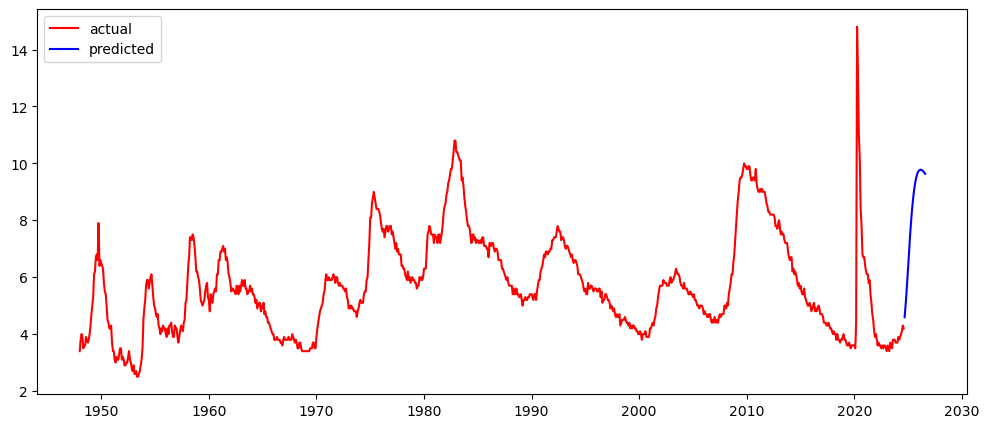

In [107]:
plt.figure(figsize=(12,5))
plt.plot(df['UNRATE'],'r',label='actual')
plt.plot(pd.DataFrame(true_predictions,index=timestep_range,columns=['UNRATE']),'b',label='predicted')
plt.legend()
plt.show();

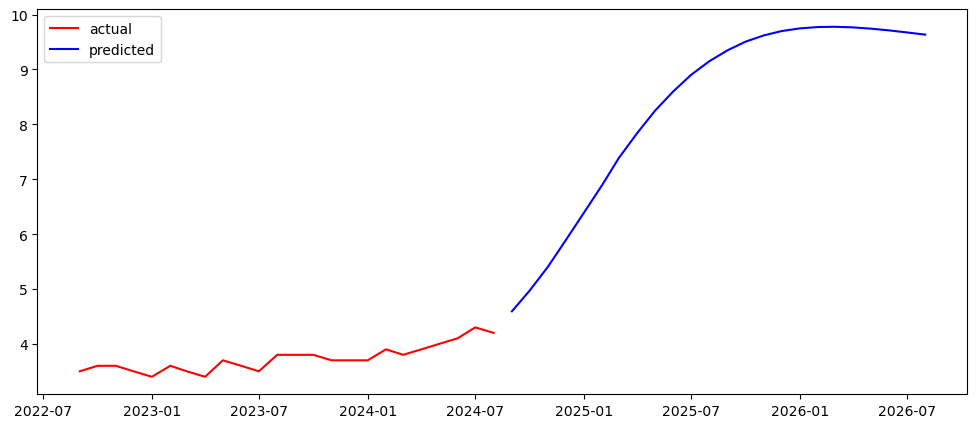

In [108]:
plt.figure(figsize=(12,5))
plt.plot(df['UNRATE'].iloc[-24:],'r',label='actual')
plt.plot(pd.DataFrame(true_predictions,index=timestep_range,columns=['UNRATE']),'b',label='predicted')
plt.legend()
plt.show();

### Saving the LSTM model

In [110]:
model.save('unemployment_rate_forecaster.keras')

In [111]:
load_model('unemployment_rate_forecaster.keras').summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 150)                 │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 274,055 (1.05 MB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 182,704 (713.69 KB)

## Forecasting Unemployment Rate using Facebook's Prophet library

In [113]:
temp = df.copy()
temp.head()

,UNRATE,SMA-7,SMA-30,SMA-60,EWMA-12,SES12,DES_add_12,DES_mul_12,TES_add_add_12,TES_add_mul_12,TES_mul_add_12,TES_mul_mul_12,HW
DATE,,,,,,,,,,,,,
1948-01-01,3.4,NaN,NaN,NaN,3.400000,3.400000,3.399986,3.400003,3.400008,3.400029,3.501547,3.402692,3.800000
1948-02-01,3.8,NaN,NaN,NaN,3.461538,3.461538,3.400871,3.391913,3.397421,3.408270,3.396026,3.399570,3.788495
1948-03-01,4.0,NaN,NaN,NaN,3.544379,3.544379,3.800871,3.790962,3.811714,3.817113,3.800284,3.806950,4.188826
1948-04-01,3.9,NaN,NaN,NaN,3.599090,3.599090,4.000871,3.990486,4.137678,4.083582,4.128719,4.073320,4.383394
1948-05-01,3.5,NaN,NaN,NaN,3.583845,3.583845,3.900871,3.890724,3.872727,3.873877,3.861283,3.863930,4.269490


In [114]:
temp = temp.reset_index()
temp = temp[['DATE','UNRATE']]
temp.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [115]:
temp.columns = ['ds','y']
temp.head()

,ds,y
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [116]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      920 non-null    datetime64[ns]
 1   y       920 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


In [245]:
temp_train = temp[:896]
temp_test = temp[896:]
temp_train.shape, temp_test.shape

((896, 2), (24, 2))

In [247]:
prophet = Prophet()
prophet.fit(temp_train)

16:35:49 - cmdstanpy - INFO - Chain [1] start processing
16:35:49 - cmdstanpy - INFO - Chain [1] done processing


In [249]:
future_df = prophet.make_future_dataframe(periods=24,freq='MS')
future_df.head()

,ds
0,1948-01-01
1,1948-02-01
2,1948-03-01
3,1948-04-01
4,1948-05-01


In [251]:
future_df.tail()

,ds
915,2024-04-01
916,2024-05-01
917,2024-06-01
918,2024-07-01
919,2024-08-01


In [253]:
forecast = prophet.predict(future_df)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1948-01-01,4.043449,2.002146,5.824652,4.043449,4.043449,-0.063970,-0.063970,-0.063970,-0.063970,-0.063970,-0.063970,0.0,0.0,0.0,3.979479
1,1948-02-01,4.048938,2.088685,5.793542,4.048938,4.048938,-0.100483,-0.100483,-0.100483,-0.100483,-0.100483,-0.100483,0.0,0.0,0.0,3.948455
2,1948-03-01,4.054072,1.920565,5.672827,4.054072,4.054072,-0.186731,-0.186731,-0.186731,-0.186731,-0.186731,-0.186731,0.0,0.0,0.0,3.867342
3,1948-04-01,4.059561,2.314873,6.125989,4.059561,4.059561,0.187951,0.187951,0.187951,0.187951,0.187951,0.187951,0.0,0.0,0.0,4.247512
4,1948-05-01,4.064873,2.362365,6.146588,4.064873,4.064873,0.150424,0.150424,0.150424,0.150424,0.150424,0.150424,0.0,0.0,0.0,4.215297


In [255]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [257]:
forecast[['yhat_lower','yhat_upper','yhat']].tail(24)

,yhat_lower,yhat_upper,yhat
896,3.850883,7.792996,5.797410
897,3.721762,7.674174,5.787610
898,3.857504,7.725322,5.778856
899,3.888748,7.708712,5.757400
900,3.848369,7.510182,5.724641
901,3.860368,7.619015,5.703888
902,3.901062,7.864031,5.963056
903,3.832964,7.730871,5.857598
904,3.858593,7.666519,5.826797
905,3.872002,7.771253,5.827486


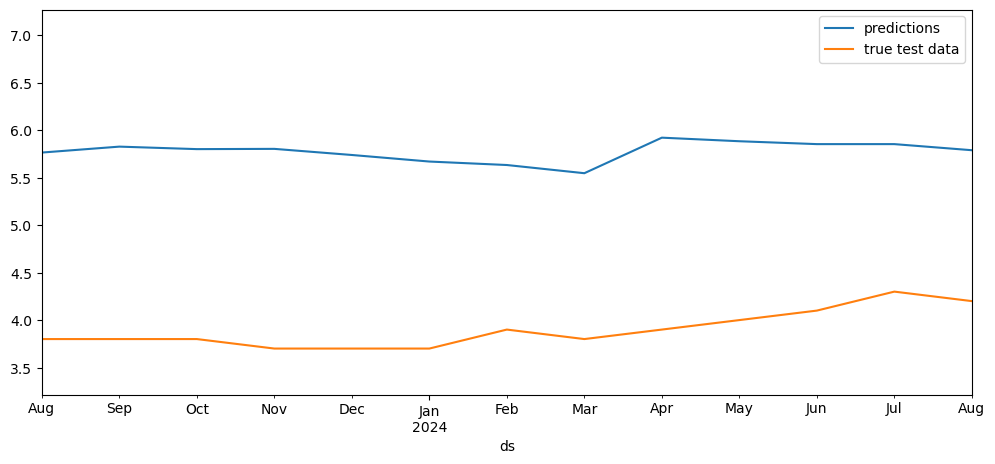

In [273]:
ax = forecast.plot(x='ds',y='yhat',label='predictions',figsize=(12,5),legend=True)
temp_test.plot(x='ds',y='y',label='true test data',legend=True,ax=ax,xlim=('2023-08-01','2024-08-01'));

In [281]:
print("MAE:", mean_absolute_error(temp_test.y,forecast['yhat'][-24:]))
print("MSE:", mean_squared_error(temp_test.y,forecast['yhat'][-24:]))
print("RMSE:", np.sqrt(mean_squared_error(temp_test.y,forecast['yhat'][-24:])))

MAE: 2.054051182004921
MSE: 4.278460353906031
RMSE: 2.0684439450722447


In [285]:
temp_test.y.mean()

3.733333333333333

In [289]:
forecast['yhat'][-24:].mean()

5.787384515338256

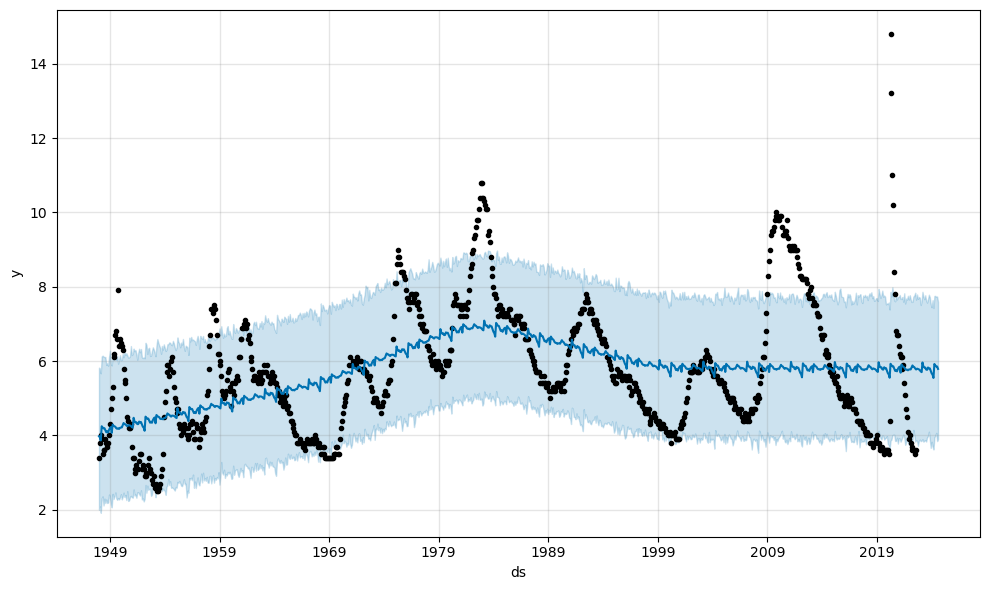

In [259]:
prophet.plot(forecast);

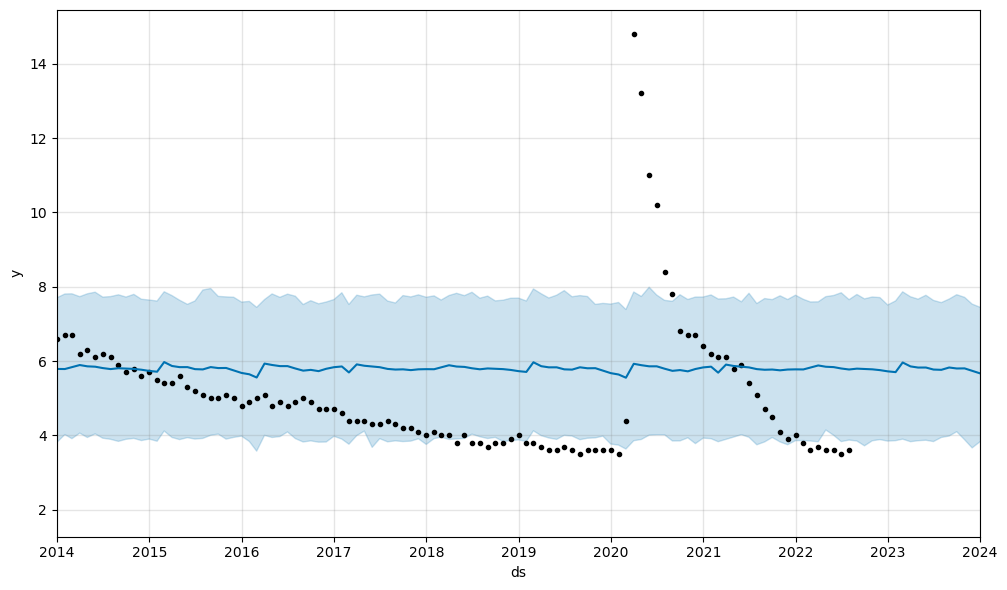

In [261]:
fig = prophet.plot(forecast)
ax = fig.gca()
ax.set_xlim([datetime(2014,1,1),datetime(2024,1,1)])
plt.show();

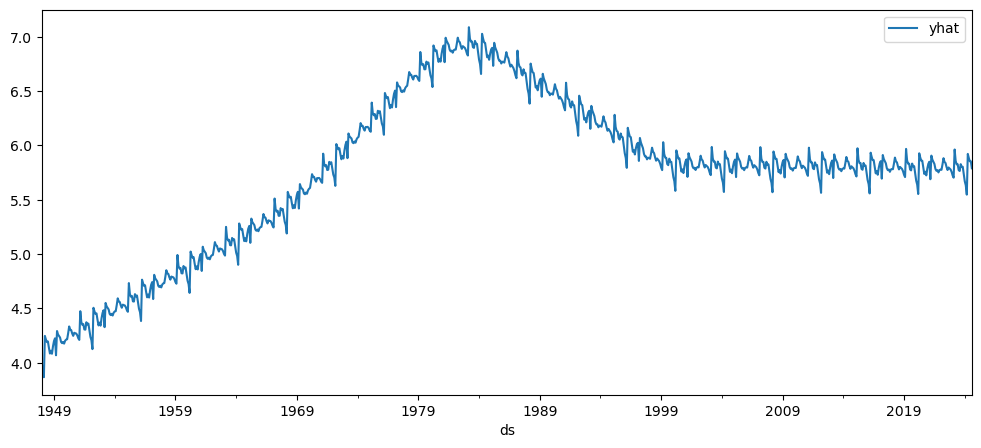

In [263]:
forecast.plot(x='ds',y='yhat',figsize=(12,5));

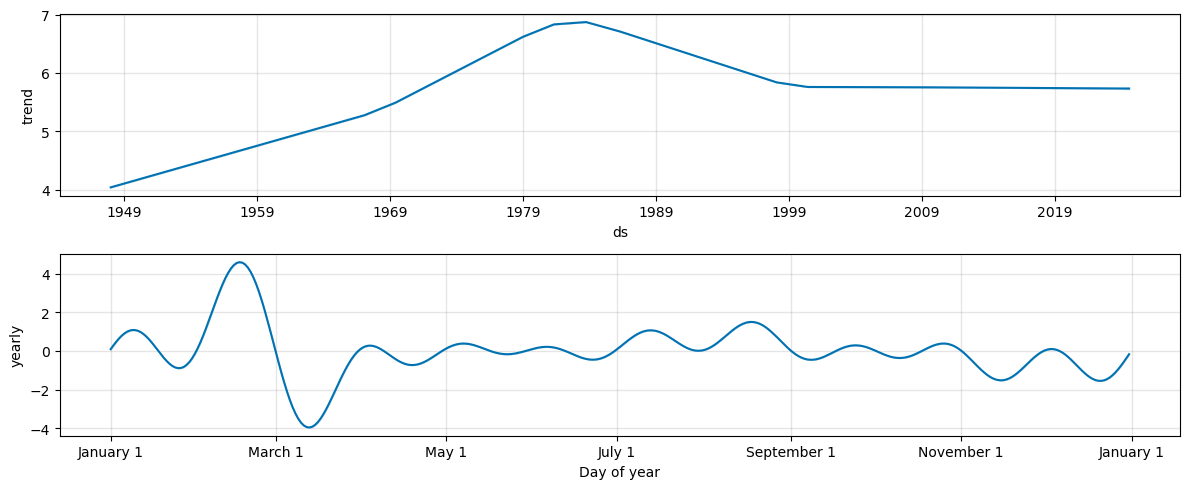

In [265]:
prophet.plot_components(forecast,figsize=(12,5));

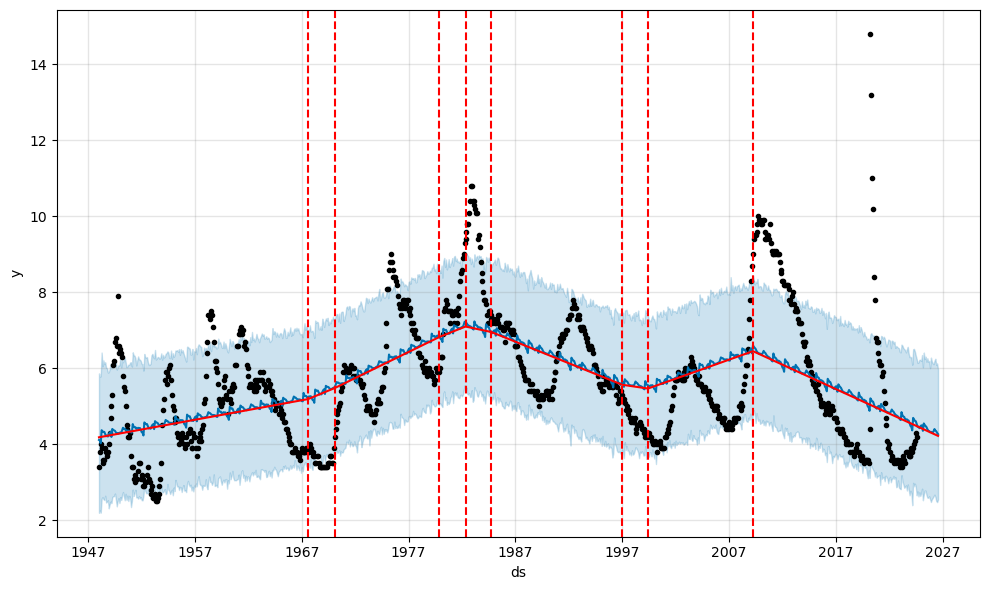

In [127]:
fig = prophet.plot(forecast)
ax = add_changepoints_to_plot(fig.gca(),prophet,forecast);

## Cross validating the Prophet model

In [291]:
# Initial training period
initial = 5 * 365
initial = str(initial) + ' days'
initial

'1825 days'

In [295]:
# Period length of cross validation
period = 5 * 365
period = str(period) + ' days'
period

'1825 days'

In [297]:
# Future forecast horizon
horizon = 2 * 365
horizon = str(horizon) + ' days'
horizon

'730 days'

In [301]:
df_cv = cross_validation(prophet,initial=initial,period=period,horizon=horizon)
df_cv.head()

  0%|          | 0/14 [00:00<?, ?it/s]

16:52:00 - cmdstanpy - INFO - Chain [1] start processing
16:52:00 - cmdstanpy - INFO - Chain [1] done processing
16:52:01 - cmdstanpy - INFO - Chain [1] start processing
16:52:01 - cmdstanpy - INFO - Chain [1] done processing
16:52:01 - cmdstanpy - INFO - Chain [1] start processing
16:52:01 - cmdstanpy - INFO - Chain [1] done processing
16:52:01 - cmdstanpy - INFO - Chain [1] start processing
16:52:02 - cmdstanpy - INFO - Chain [1] done processing
16:52:02 - cmdstanpy - INFO - Chain [1] start processing
16:52:02 - cmdstanpy - INFO - Chain [1] done processing
16:52:02 - cmdstanpy - INFO - Chain [1] start processing
16:52:03 - cmdstanpy - INFO - Chain [1] done processing
16:52:03 - cmdstanpy - INFO - Chain [1] start processing
16:52:03 - cmdstanpy - INFO - Chain [1] done processing
16:52:03 - cmdstanpy - INFO - Chain [1] start processing
16:52:03 - cmdstanpy - INFO - Chain [1] done processing
16:52:03 - cmdstanpy - INFO - Chain [1] start processing
16:52:04 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1955-09-01,4.045017,2.489105,5.702190,4.1,1955-08-18
1,1955-10-01,4.306651,2.537348,5.895427,4.3,1955-08-18
2,1955-11-01,4.275790,2.842312,5.867924,4.2,1955-08-18
3,1955-12-01,4.151981,2.563641,5.747536,4.2,1955-08-18
4,1956-01-01,3.520602,1.895178,5.158017,4.0,1955-08-18


In [303]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,80 days,2.465607,1.570225,1.219711,0.199134,0.148118,0.201379,0.545455
1,82 days,2.471013,1.571946,1.230952,0.200448,0.148118,0.202741,0.545455
2,83 days,2.559579,1.599868,1.276946,0.206778,0.222793,0.208275,0.515152
3,84 days,2.490508,1.578134,1.239932,0.197474,0.148118,0.200669,0.545455
4,85 days,2.390372,1.546083,1.196852,0.189406,0.147489,0.190301,0.575758
...,...,...,...,...,...,...,...,...
299,725 days,4.028910,2.007214,1.743674,0.317424,0.272717,0.292707,0.333333
300,726 days,3.888243,1.971863,1.686939,0.312555,0.272717,0.287029,0.363636
301,728 days,3.714485,1.927300,1.648184,0.304467,0.240730,0.282254,0.363636
302,729 days,3.918680,1.979566,1.684023,0.319389,0.240730,0.289034,0.363636


## Plotting cross validation results

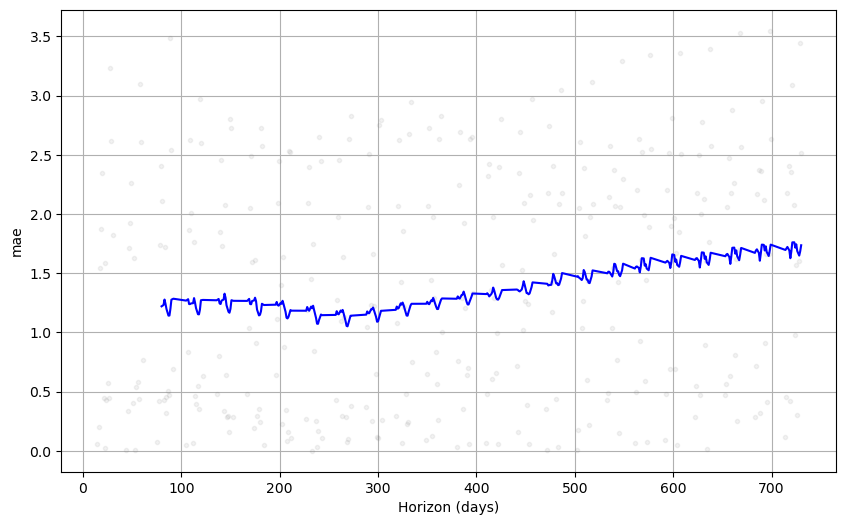

In [311]:
plot_cross_validation_metric(df_cv,metric='mae');

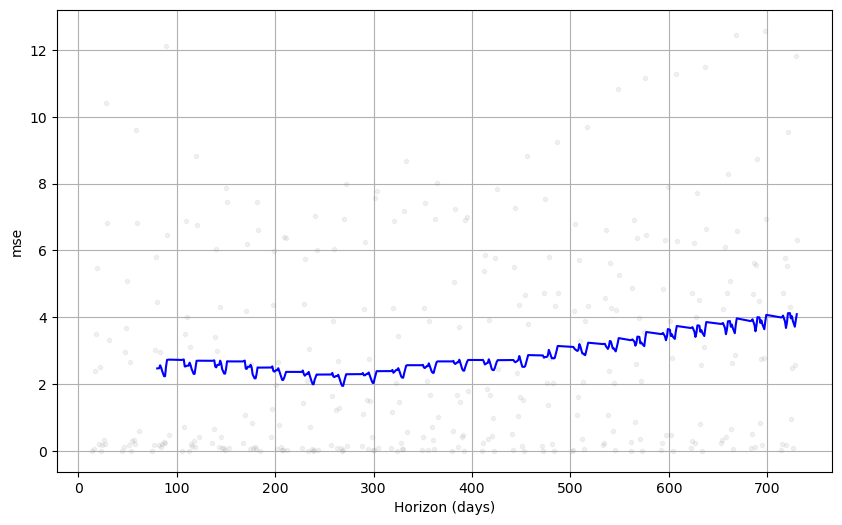

In [307]:
plot_cross_validation_metric(df_cv,metric='mse');

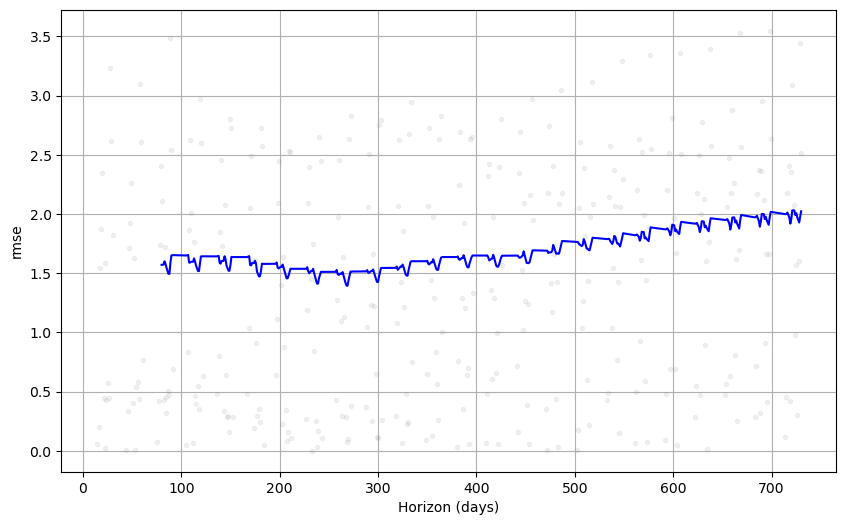

In [309]:
plot_cross_validation_metric(df_cv,metric='rmse');

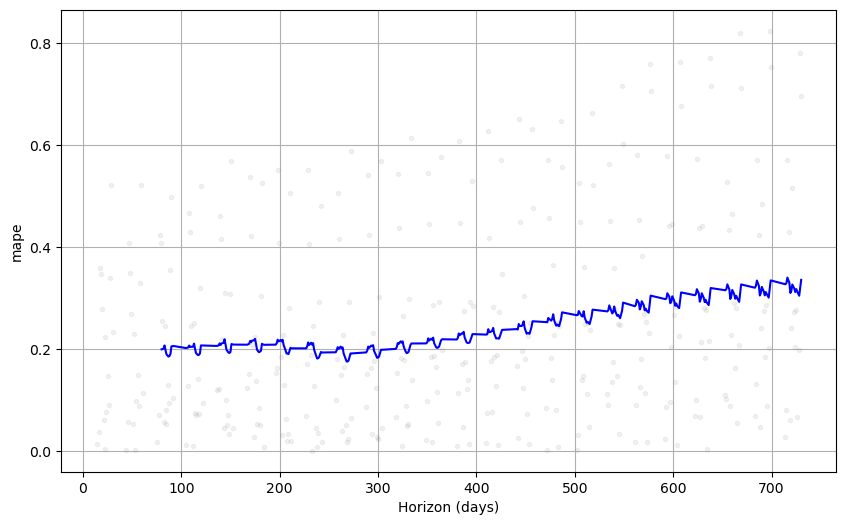

In [313]:
plot_cross_validation_metric(df_cv,metric='mape');

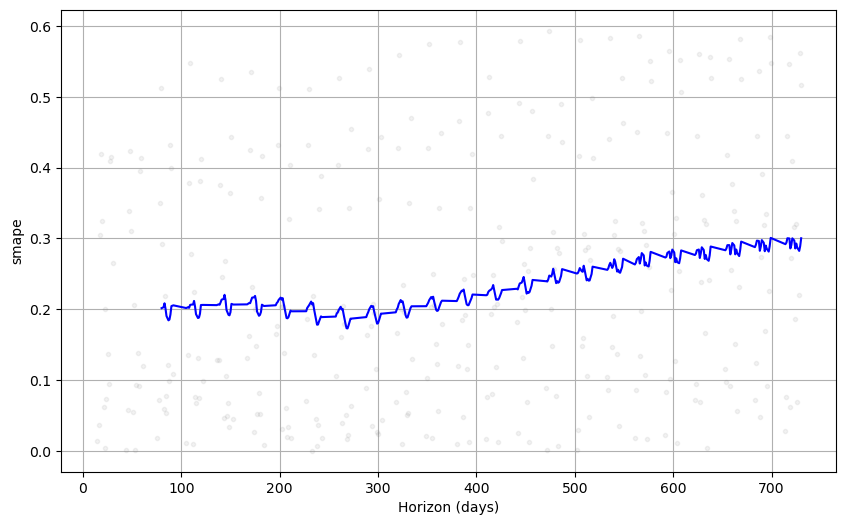

In [315]:
plot_cross_validation_metric(df_cv,metric='smape');

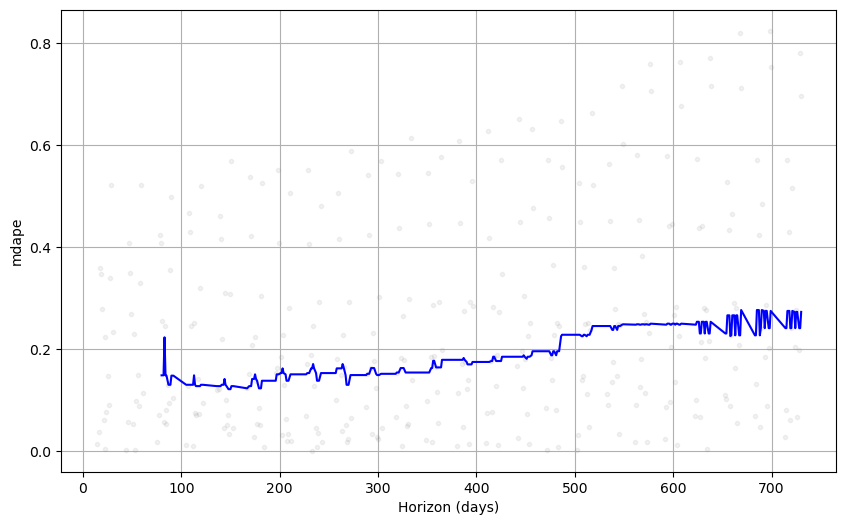

In [317]:
plot_cross_validation_metric(df_cv,metric='mdape');

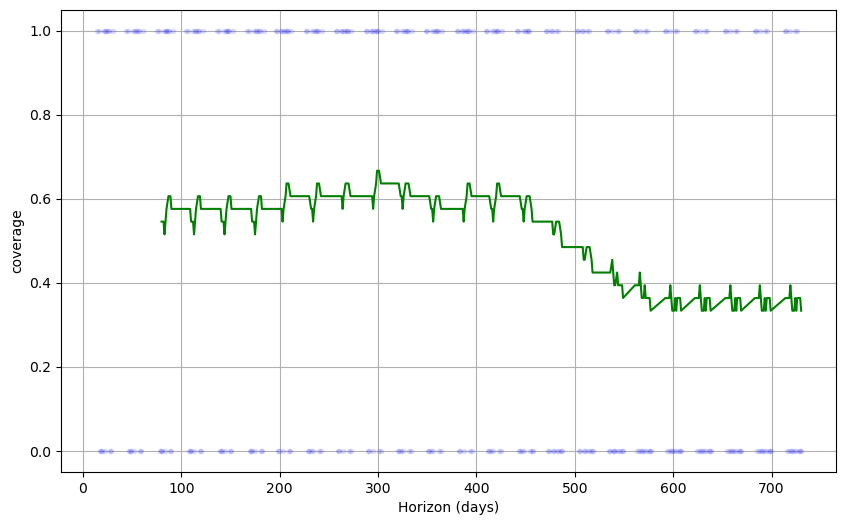

In [319]:
plot_cross_validation_metric(df_cv,metric='coverage',color='g',point_color='blue');

## Applying seasonality to the Prophet model

In [128]:
prophet = Prophet(seasonality_mode='multiplicative')
prophet.fit(temp)

16:31:25 - cmdstanpy - INFO - Chain [1] start processing
16:31:25 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
future_df = prophet.make_future_dataframe(periods=24,freq='MS')
forecast = prophet.predict(future_df)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1948-01-01,4.174577,2.331588,5.818555,4.174577,4.174577,-0.004490,-0.004490,-0.004490,-0.004490,-0.004490,-0.004490,0.0,0.0,0.0,4.155834
1,1948-02-01,4.178656,2.198189,5.858896,4.178656,4.178656,-0.023181,-0.023181,-0.023181,-0.023181,-0.023181,-0.023181,0.0,0.0,0.0,4.081790
2,1948-03-01,4.182472,2.284691,5.755895,4.182472,4.182472,-0.032982,-0.032982,-0.032982,-0.032982,-0.032982,-0.032982,0.0,0.0,0.0,4.044524
3,1948-04-01,4.186551,2.539474,5.947563,4.186551,4.186551,0.035808,0.035808,0.035808,0.035808,0.035808,0.035808,0.0,0.0,0.0,4.336463
4,1948-05-01,4.190499,2.537188,6.054267,4.190499,4.190499,0.030152,0.030152,0.030152,0.030152,0.030152,0.030152,0.0,0.0,0.0,4.316851


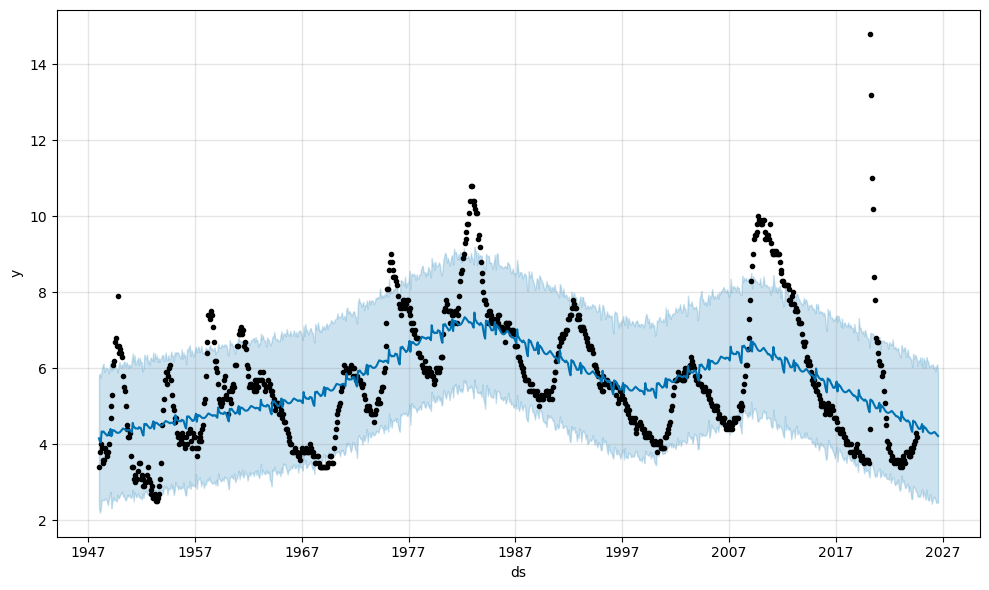

In [130]:
prophet.plot(forecast);

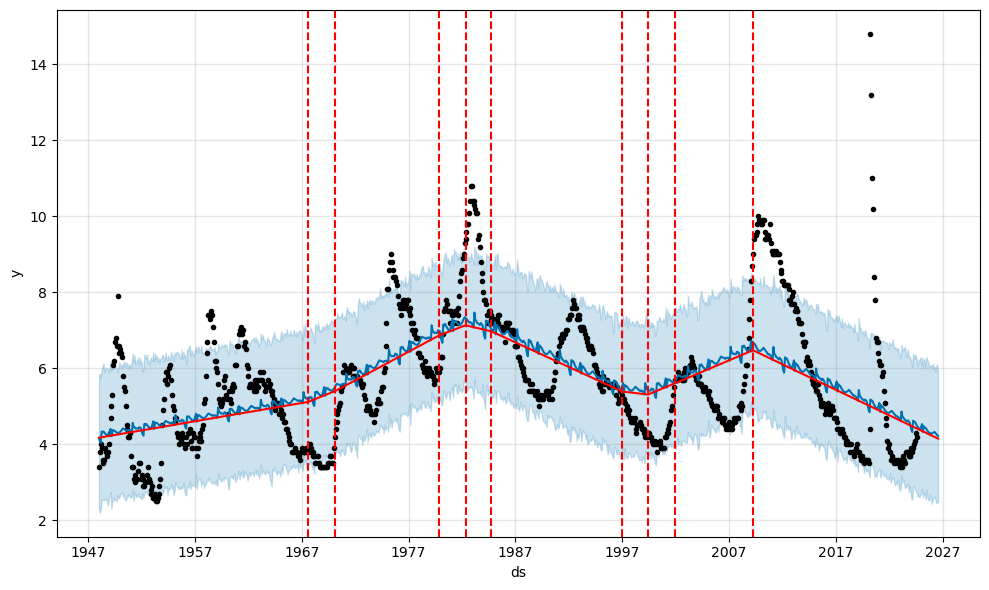

In [131]:
fig = prophet.plot(forecast)
ax = add_changepoints_to_plot(fig.gca(),prophet,forecast);

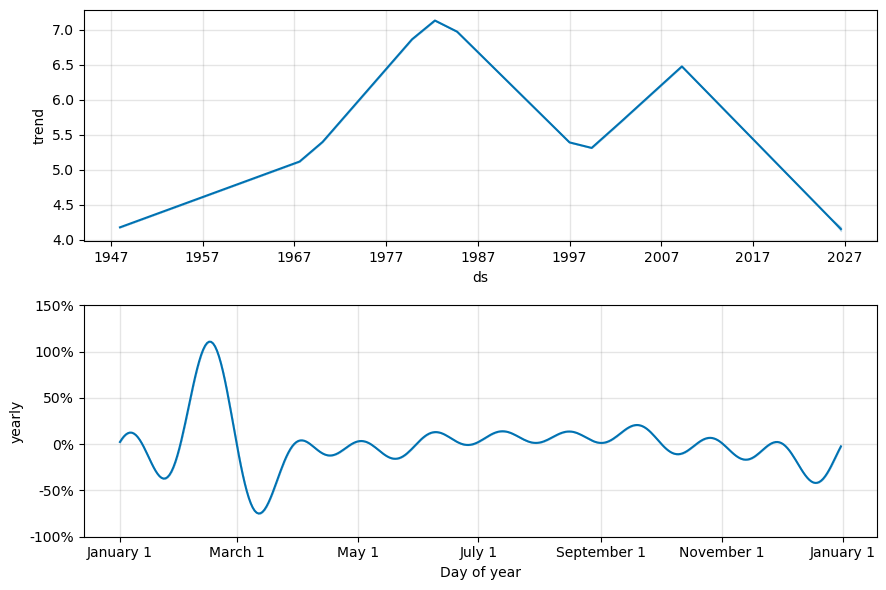

In [132]:
prophet.plot_components(forecast);

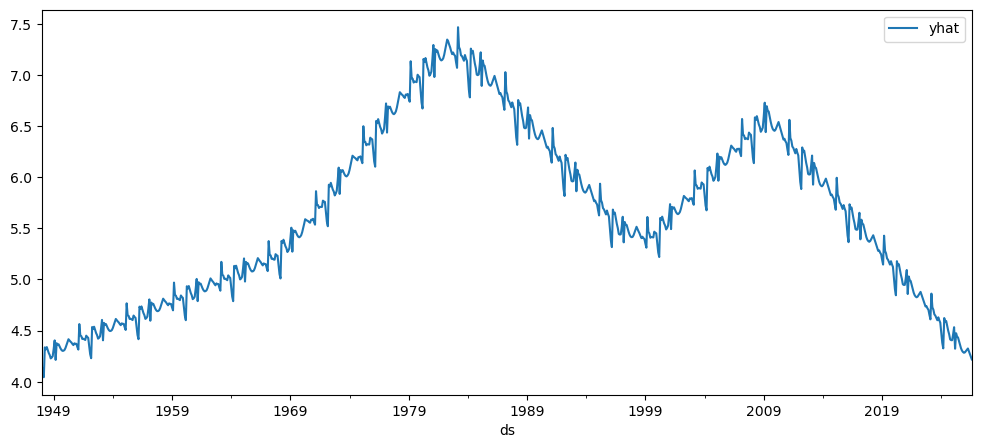

In [133]:
forecast.plot(x='ds',y='yhat',figsize=(12,5));